# 2D Kernel with SPECFEM2D - Multiple Receivers
By Andrea R.  
Utility functions written by Ridvan Orsvuran.  
Following file structure as in the Seisflows example (By Bryant Chow)

In [1]:
import os
import shutil
import matplotlib
import numpy as np
import FunctionsPlotBin
import matplotlib.pyplot as plt

from UtilityFunctions import read_trace, specfem2D_prep_save_forward, replace_line, save_trace, specfem2D_prep_adjoint, grid
from scipy.integrate import simps

# Domain: 
2D:   
x-dir = 4000 m   
z-dir = 4000 m   

### Source location
original x:    1000 m     
original z:    2000 m  

### Output stations locations: 
Station #1   AAS0001                             
original x:    3000 m  
original z:    2000 m  

Station #2   AAS0002                             
original x:    2000 m  
original z:    3000 m  

Station #3   AAS0003                             
original x:    2000 m  
original z:    1000 m  

### Boundary conditions 
Type: STACEY_ABSORBING_CONDITIONS  
absorbbottom                    = true  
absorbright                     = true  
absorbtop                       = true  
absorbleft                      = true  

### Velocity model:

#### Initial model:  
Model: P (or PI) velocity min,max =    3000 m/s              
Model: S velocity min,max         =    1800 m/s        
Model: density min,max            =    2700 kg/m3           

#### True model (~1% perturbation of the Vs - initial model):   
Model: P (or PI) velocity min,max =    3000 m/s                
Model: S velocity min,max         =    1820 m/s          
Model: density min,max            =    2700 kg/m3      

### Set Specfem2D and work directories 

In [2]:
specfem2d_path = "/home/masa/" # for desktop machine
#specfem2d_path = "/home/masan/" # for laptop 
EXAMPLE = os.path.join(os.getcwd(),"Examples", "DATA_Example01")
WORKDIR = os.path.join(os.getcwd(),"work")

# Incase we've run this docs page before, delete the working directory before remaking
if os.path.exists(WORKDIR):
    shutil.rmtree(WORKDIR)
os.makedirs(WORKDIR, exist_ok=True)

In [3]:
# Distribute the necessary file structure of the SPECFEM2D repository that we will reference
SPECFEM2D_ORIGINAL = os.path.join(specfem2d_path, "specfem2d") 
SPECFEM2D_BIN_ORIGINAL = os.path.join(SPECFEM2D_ORIGINAL, "bin")
SPECFEM2D_DATA_ORIGINAL = os.path.join(SPECFEM2D_ORIGINAL, "DATA")

# The SPECFEM2D working directory that we will create separate from the downloaded repo
SPECFEM2D_WORKDIR = os.path.join(WORKDIR, "ExampleKernelMultiReceiver")
SPECFEM2D_BIN = os.path.join(SPECFEM2D_WORKDIR, "bin")
SPECFEM2D_DATA = os.path.join(SPECFEM2D_WORKDIR, "DATA")
SPECFEM2D_OUTPUT = os.path.join(SPECFEM2D_WORKDIR, "OUTPUT_FILES")

# Pre-defined locations of velocity models we will generate using the solver
SPECFEM2D_MODEL_INIT = os.path.join(SPECFEM2D_WORKDIR, "OUTPUT_FILES_INIT")
SPECFEM2D_MODEL_TRUE = os.path.join(SPECFEM2D_WORKDIR, "OUTPUT_FILES_TRUE")

In [4]:
# Copy the binary files incase we update the source code. These can also be symlinked.
shutil.copytree(SPECFEM2D_BIN_ORIGINAL, SPECFEM2D_BIN)

# Copy the DATA/ directory
shutil.copytree(EXAMPLE, SPECFEM2D_DATA)
!pwd
!ls

/home/masa/FWI_MAH575/JupyterNotebooks
A_InstallingSpecfem2d.ipynb		export.py
B_Specfem2D_Example.ipynb		FunctionsPlotBin.py
C_Specfem2D_Tomofile.ipynb		__pycache__
D_Specfem2D_Kernel.ipynb		README.md
D_Specfem2D_Kernel_MultiReceiver.ipynb	SPECFEM2D_Analysis.ipynb
D_Specfem2D_Kernel_P.ipynb		UtilityFunctions.py
E_Specfem2D_ExampleLayeredModel.ipynb	work
Examples


In [5]:
# Create a new STATIONS file with multiple receivers
stations_content = """S0001    AA          3000.0000000        2000.0000000       0.0         0.0
S0002    AA          2000.0000000        3000.0000000       0.0         0.0
S0003    AA          2000.0000000        1000.0000000       0.0         0.0
"""

with open(os.path.join(SPECFEM2D_DATA, "STATIONS"), "w") as f:
    f.write(stations_content)

### Generate true model

In [6]:
os.chdir(SPECFEM2D_DATA)
specfem2D_prep_save_forward("Par_file")
# Modify the Par_file to increase Initial Vs by ~1% 
replace_line("Par_file",33,"P_SV                            = .false. \n")
replace_line("Par_file",262,'1 1 2700.d0 3000.d0 1820.d0 0 0 9999 9999 0 0 0 0 0 0 \n')

In [7]:
# create the OUTPUT_FILES directory before running 
os.chdir(SPECFEM2D_WORKDIR)
if os.path.exists(SPECFEM2D_OUTPUT):
    shutil.rmtree(SPECFEM2D_OUTPUT)
os.mkdir(SPECFEM2D_OUTPUT)
!ls

bin  DATA  OUTPUT_FILES


In [8]:
os.chdir(SPECFEM2D_WORKDIR)
!bin/xmeshfem2D > OUTPUT_FILES/mesher_log.txt
!bin/xspecfem2D > OUTPUT_FILES/solver_log.txt

# Move the model files (*.bin) into the OUTPUT_FILES directory
!mv DATA/*bin OUTPUT_FILES

# Make sure we don't overwrite this target model when creating our initial model in the next step
!mv OUTPUT_FILES OUTPUT_FILES_TRUE

!head OUTPUT_FILES_TRUE/solver_log.txt
!tail OUTPUT_FILES_TRUE/solver_log.txt


 **********************************************
 **** Specfem 2-D Solver - MPI version     ****
 **********************************************

 Running Git version of the code corresponding to 98741db1a0c8082ca57364f5b17ea95df6cbf1c2
 dating 2023-12-21 00:21:37 +0100

 There are            1  MPI processes
 Processes are numbered from 0 to            0
 -------------------------------------------------------------------------------
 Program SPECFEM2D: 
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 Test of SPECFEM2D with curved interfaces
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 D a t e : 09 - 03 - 2025                                 T i m e  : 22:31:41
 -------------------------------------------------------------------------------
 --------------

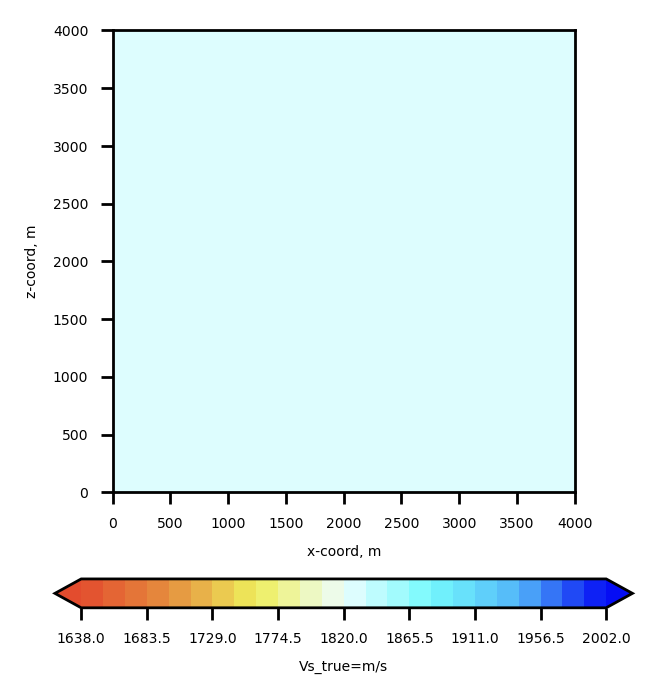

In [9]:
x_coords_file = 'OUTPUT_FILES_TRUE/proc000000_x.bin'
z_coords_file = 'OUTPUT_FILES_TRUE/proc000000_z.bin'
Vs_true       = 'OUTPUT_FILES_TRUE/proc000000_vs.bin'

# Plot 
FunctionsPlotBin.plotbin(x_coords_file,z_coords_file,Vs_true,SPECFEM2D_WORKDIR+'/Vs_true','Vs_true=m/s')

### Generate initial model

In [10]:
os.chdir(SPECFEM2D_DATA)
replace_line("Par_file",262,'1 1 2700.d0 3000.d0 1800.d0 0 0 9999 9999 0 0 0 0 0 0 \n')

In [11]:
# create the OUTPUT_FILES directory before running 
os.chdir(SPECFEM2D_WORKDIR)
if os.path.exists(SPECFEM2D_OUTPUT):
    shutil.rmtree(SPECFEM2D_OUTPUT)
os.mkdir(SPECFEM2D_OUTPUT)
!ls

bin  DATA  OUTPUT_FILES  OUTPUT_FILES_TRUE  Vs_true.pdf


In [12]:
os.chdir(SPECFEM2D_WORKDIR)
!bin/xmeshfem2D > OUTPUT_FILES/mesher_log.txt
!bin/xspecfem2D > OUTPUT_FILES/solver_log.txt

# Move the model files (*.bin) into the OUTPUT_FILES directory
# The binary files of the velocity models are stored in DATA after running xspecfem2D
!mv DATA/*bin OUTPUT_FILES

# Store output files of initial model
!mv OUTPUT_FILES OUTPUT_FILES_INIT

!head OUTPUT_FILES_INIT/solver_log.txt
!tail OUTPUT_FILES_INIT/solver_log.txt


 **********************************************
 **** Specfem 2-D Solver - MPI version     ****
 **********************************************

 Running Git version of the code corresponding to 98741db1a0c8082ca57364f5b17ea95df6cbf1c2
 dating 2023-12-21 00:21:37 +0100

 There are            1  MPI processes
 Processes are numbered from 0 to            0
 -------------------------------------------------------------------------------
 Program SPECFEM2D: 
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 Test of SPECFEM2D with curved interfaces
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 D a t e : 09 - 03 - 2025                                 T i m e  : 22:31:47
 -------------------------------------------------------------------------------
 --------------

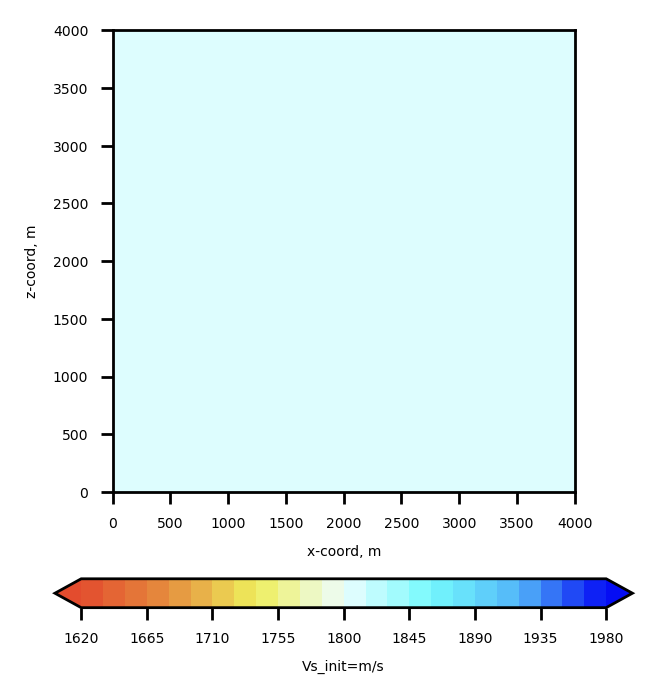

In [13]:
x_coords_file = 'OUTPUT_FILES_INIT/proc000000_x.bin'
z_coords_file = 'OUTPUT_FILES_INIT/proc000000_z.bin'
Vs_true       = 'OUTPUT_FILES_INIT/proc000000_vs.bin'

# Plot 
FunctionsPlotBin.plotbin(x_coords_file,z_coords_file,Vs_true,SPECFEM2D_WORKDIR+'/Vs_init','Vs_init=m/s')

### 3. Plot synthetic seismograms for all receivers

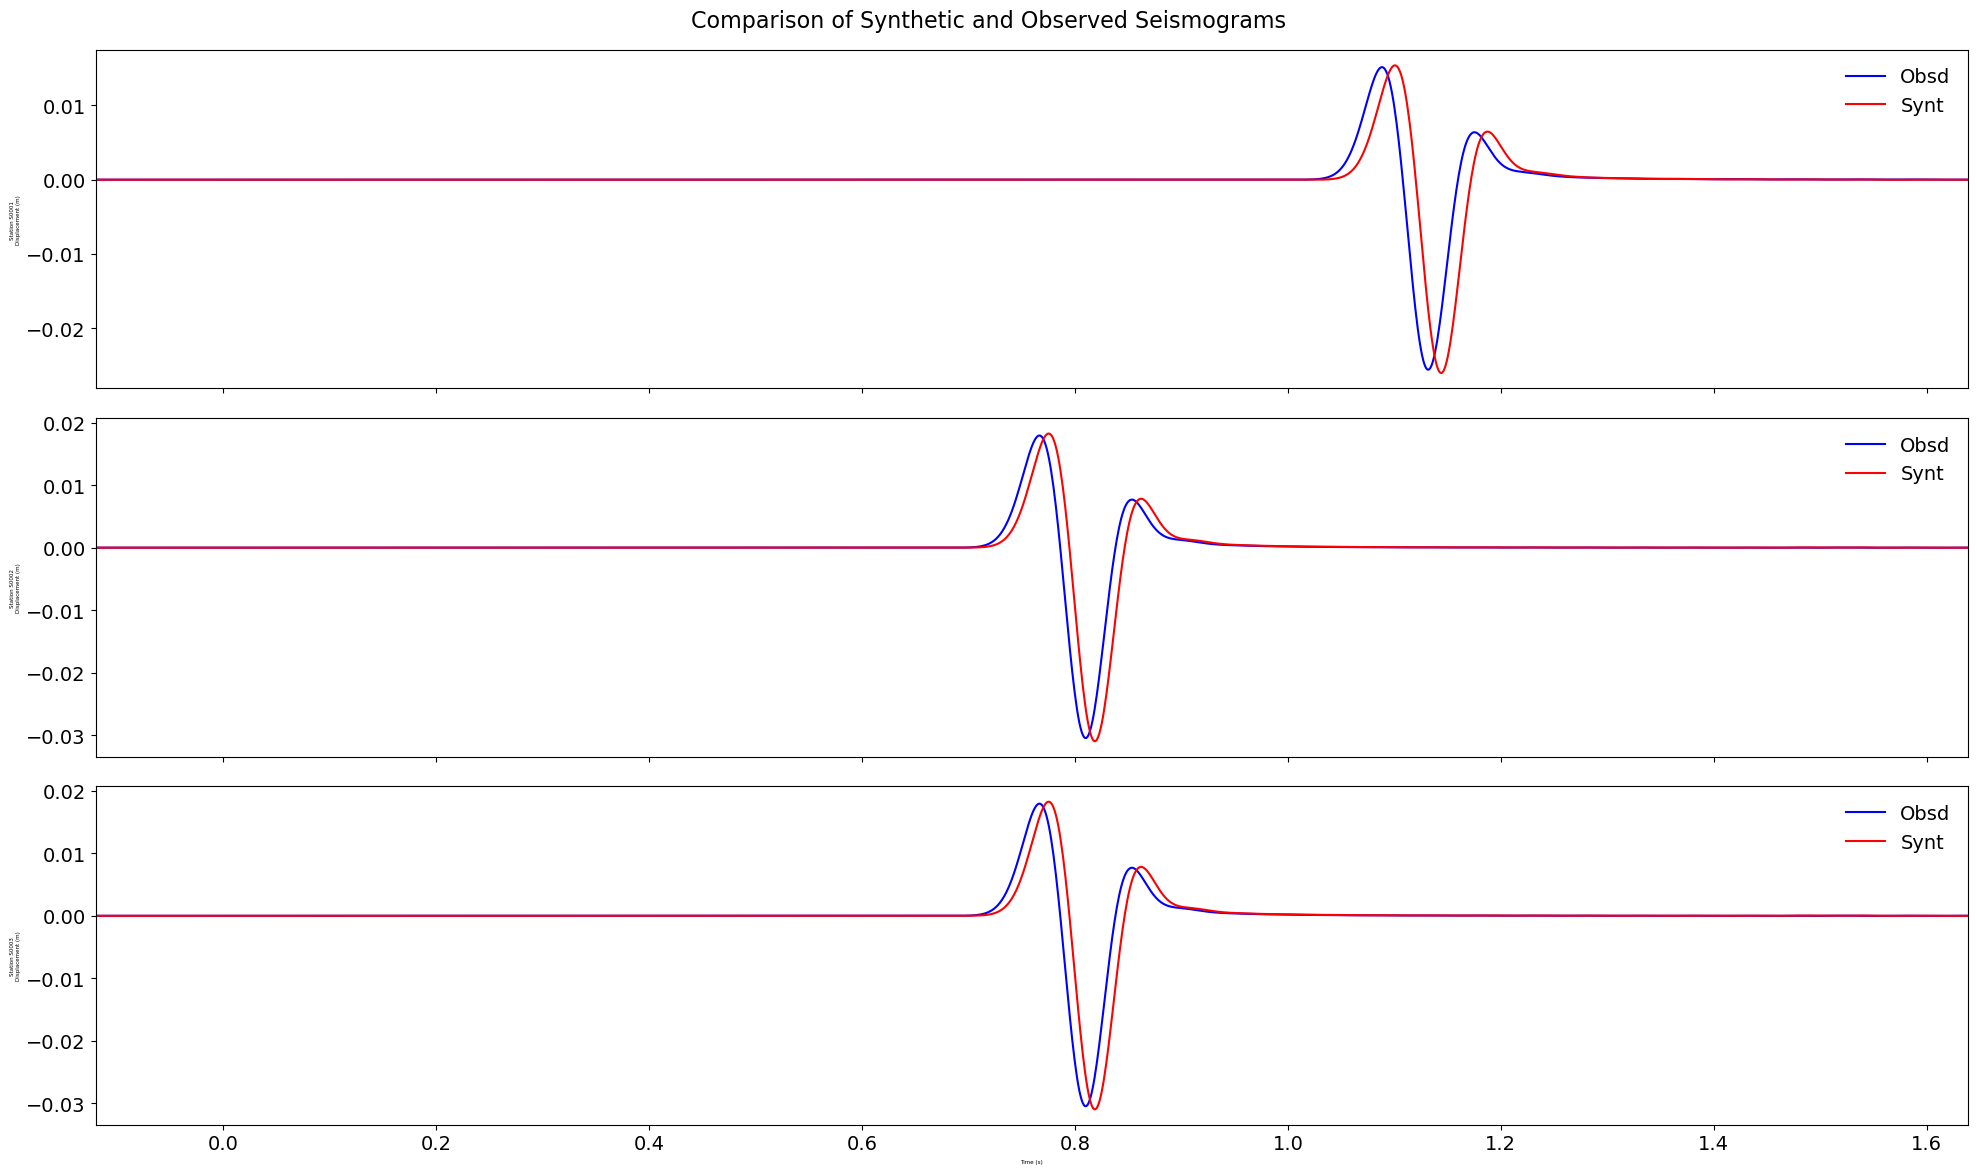

In [14]:
os.chdir(SPECFEM2D_WORKDIR)
station_ids = ["S0001", "S0002", "S0003"]

fig, axes = plt.subplots(len(station_ids), 1, figsize=(20, 12), sharex=True)
matplotlib.rcParams.update({'font.size': 14})

for i, station_id in enumerate(station_ids):
    # Read synthetic seismogram
    obsd = read_trace(os.path.join("OUTPUT_FILES_TRUE",f"AA.{station_id}.BXY.semd"))
    synt = read_trace(os.path.join("OUTPUT_FILES_INIT",f"AA.{station_id}.BXY.semd"))

    # Process data
    obsd.detrend("simple")
    obsd.taper(0.05)
    obsd.filter("bandpass", freqmin=0.01, freqmax=20)

    synt.detrend("simple")
    synt.taper(0.05)
    synt.filter("bandpass", freqmin=0.01, freqmax=20)
    
    # Plot
    axes[i].plot(obsd.times()+obsd.stats.b, obsd.data, "b", label="Obsd")
    axes[i].plot(synt.times()+synt.stats.b, synt.data, "r", label="Synt")
    axes[i].set_xlim(synt.stats.b, synt.times()[-1]+synt.stats.b)
    axes[i].legend(frameon=False)
    axes[i].set_ylabel(f"Station {station_id}\nDisplacement (m)")
    axes[i].tick_params(axis='both',which='major',labelsize=14)

axes[-1].set_xlabel("Time (s)")
fig.suptitle("Comparison of Synthetic and Observed Seismograms", fontsize=16)
plt.tight_layout()

In [15]:
os.chdir(SPECFEM2D_WORKDIR)
station_ids = ["S0001", "S0002", "S0003"]

# 1. Cross-correlation traveltime misfit
def calculate_cc_traveltime_misfit(obsd, synt):
    # Cross correlation to find time shift
    cc = np.correlate(obsd.data, synt.data, mode='full')
    dt = obsd.stats.delta
    shift_samples = np.argmax(cc) - (len(obsd.data) - 1)
    time_shift = shift_samples * dt
    
    # Misfit calculation
    misfit = 0.5 * time_shift**2
    
    # Adjoint source calculation
    # Get the derivative of synthetic
    deriv = np.gradient(synt.data, dt)
    
    # Normalize by energy of the derivative
    norm_factor = 1.0 / np.sum(deriv**2 * dt)
    adj_source = time_shift * norm_factor * deriv
    
    return misfit, adj_source, time_shift

# 2. Cross-correlation amplitude misfit
def calculate_cc_amplitude_misfit(obsd, synt):
    # Cross correlation to find amplitude difference
    cc = np.correlate(obsd.data, synt.data, mode='full')
    max_cc_idx = np.argmax(cc) - (len(obsd.data) - 1)
    
    # Shift the synthetic to align with observed
    if max_cc_idx > 0:
        synt_aligned = np.concatenate([np.zeros(max_cc_idx), synt.data[:-max_cc_idx]])
    elif max_cc_idx < 0:
        synt_aligned = np.concatenate([synt.data[-max_cc_idx:], np.zeros(-max_cc_idx)])
    else:
        synt_aligned = synt.data
    
    # Calculate amplitude ratio
    energy_obs = np.sum(obsd.data**2)
    energy_syn = np.sum(synt_aligned**2)
    
    if energy_syn > 0:
        amplitude_ratio = np.sqrt(energy_obs / energy_syn)
    else:
        amplitude_ratio = 1.0
    
    # Amplitude anomaly
    dlnA = np.log(amplitude_ratio)
    
    # Misfit
    misfit = 0.5 * dlnA**2
    
    # Adjoint source is the time-reversed synthetic scaled by the amplitude anomaly
    norm_factor = 1.0 / np.sum(synt_aligned**2 * obsd.stats.delta)
    adj_source = dlnA * norm_factor * synt_aligned
    
    return misfit, adj_source, dlnA

# 3. Waveform misfit
def calculate_waveform_misfit(obsd, synt):
    # Waveform difference
    diff = synt.data - obsd.data
    
    # Misfit calculation
    dt = obsd.stats.delta
    misfit = 0.5 * np.sum(diff**2) * dt
    
    # Adjoint source is simply the difference
    adj_source = diff
    
    # Calculate normalized RMS error
    rms_error = np.sqrt(np.mean(diff**2)) / np.max(np.abs(obsd.data))
    
    return misfit, adj_source, rms_error

# Dictionary to store all misfit types
misfit_names = {
    "cc_traveltime": "Cross-correlation Traveltime",
    "cc_amplitude": "Cross-correlation Amplitude",
    "waveform": "Waveform"
}

misfit_types = {
    "cc_traveltime": {"function": calculate_cc_traveltime_misfit, "total": 0, "adjoint_sources": {}, "measurements": {}},
    "cc_amplitude": {"function": calculate_cc_amplitude_misfit, "total": 0, "adjoint_sources": {}, "measurements": {}},
    "waveform": {"function": calculate_waveform_misfit, "total": 0, "adjoint_sources": {}, "measurements": {}}
}

# Calculate all misfit types for all stations
for station_id in station_ids:
    # Check if seismogram files exist
    obs_file = os.path.join("OUTPUT_FILES_TRUE", f"AA.{station_id}.BXY.semd")
    syn_file = os.path.join("OUTPUT_FILES_INIT", f"AA.{station_id}.BXY.semd")
    
    if not os.path.exists(obs_file) or not os.path.exists(syn_file):
        print(f"Warning: Seismogram files not found for station {station_id}")
        continue
        
    # Read and process seismograms
    obsd = read_trace(obs_file)
    synt = read_trace(syn_file)
    
    # Check that number of time steps matches what we expect from Par_file
    # Get NSTEP from Par_file
    par_file_path = os.path.join(SPECFEM2D_DATA, "Par_file")
    if os.path.exists(par_file_path):
        with open(par_file_path, 'r') as f:
            par_file = f.readlines()
        
        nstep_line = [line for line in par_file if 'NSTEP' in line and not line.strip().startswith('#')]
        if nstep_line:
            expected_nstep = int(nstep_line[0].split('=')[1].split('#')[0].strip())
            
            actual_nstep = len(obsd.data)
            if actual_nstep != expected_nstep:
                print(f"Warning: Station {station_id} has {actual_nstep} time steps, but Par_file specifies {expected_nstep}")

    # Process data
    obsd.detrend("simple")
    obsd.taper(0.05)
    obsd.filter("bandpass", freqmin=0.01, freqmax=20)

    synt.detrend("simple")
    synt.taper(0.05)
    synt.filter("bandpass", freqmin=0.01, freqmax=20)
    
    # Calculate each misfit type
    for misfit_type, misfit_data in misfit_types.items():
        try:
            station_misfit, adj_source, measurement = misfit_data["function"](obsd, synt)
            misfit_data["total"] += station_misfit
            misfit_data["measurements"][station_id] = measurement
            
            # Create adjoint source trace
            adj = synt.copy()
            adj.data = adj_source
            adj.detrend("simple")
            adj.taper(0.05)
            adj.filter("bandpass", freqmin=0.01, freqmax=20)
            
            misfit_data["adjoint_sources"][station_id] = adj
        except Exception as e:
            print(f"Error calculating {misfit_type} misfit for station {station_id}: {e}")

# Print total misfits and measurements
print("Misfit measurements by station:")
print("-" * 60)
for misfit_type, misfit_data in misfit_types.items():
    print(f"\n{misfit_names[misfit_type]} misfit:")
    print(f"  Total misfit: {misfit_data['total']:.6e}")
    
    print("  Station measurements:")
    for station_id, measurement in misfit_data["measurements"].items():
        if misfit_type == "cc_traveltime":
            print(f"    {station_id}: Time shift = {measurement:.6f} s")
        elif misfit_type == "cc_amplitude":
            print(f"    {station_id}: ln(Amplitude ratio) = {measurement:.6f}")
        elif misfit_type == "waveform":
            print(f"    {station_id}: Normalized RMS error = {measurement:.6f}")

Misfit measurements by station:
------------------------------------------------------------

Cross-correlation Traveltime misfit:
  Total misfit: 1.506450e-04
  Station measurements:
    S0001: Time shift = -0.012100 s
    S0002: Time shift = -0.008800 s
    S0003: Time shift = -0.008800 s

Cross-correlation Amplitude misfit:
  Total misfit: 4.122593e-04
  Station measurements:
    S0001: ln(Amplitude ratio) = -0.016587
    S0002: ln(Amplitude ratio) = -0.016574
    S0003: ln(Amplitude ratio) = -0.016574

Waveform misfit:
  Total misfit: 1.491009e-05
  Station measurements:
    S0001: Normalized RMS error = 0.102371
    S0002: Normalized RMS error = 0.073660
    S0003: Normalized RMS error = 0.073660


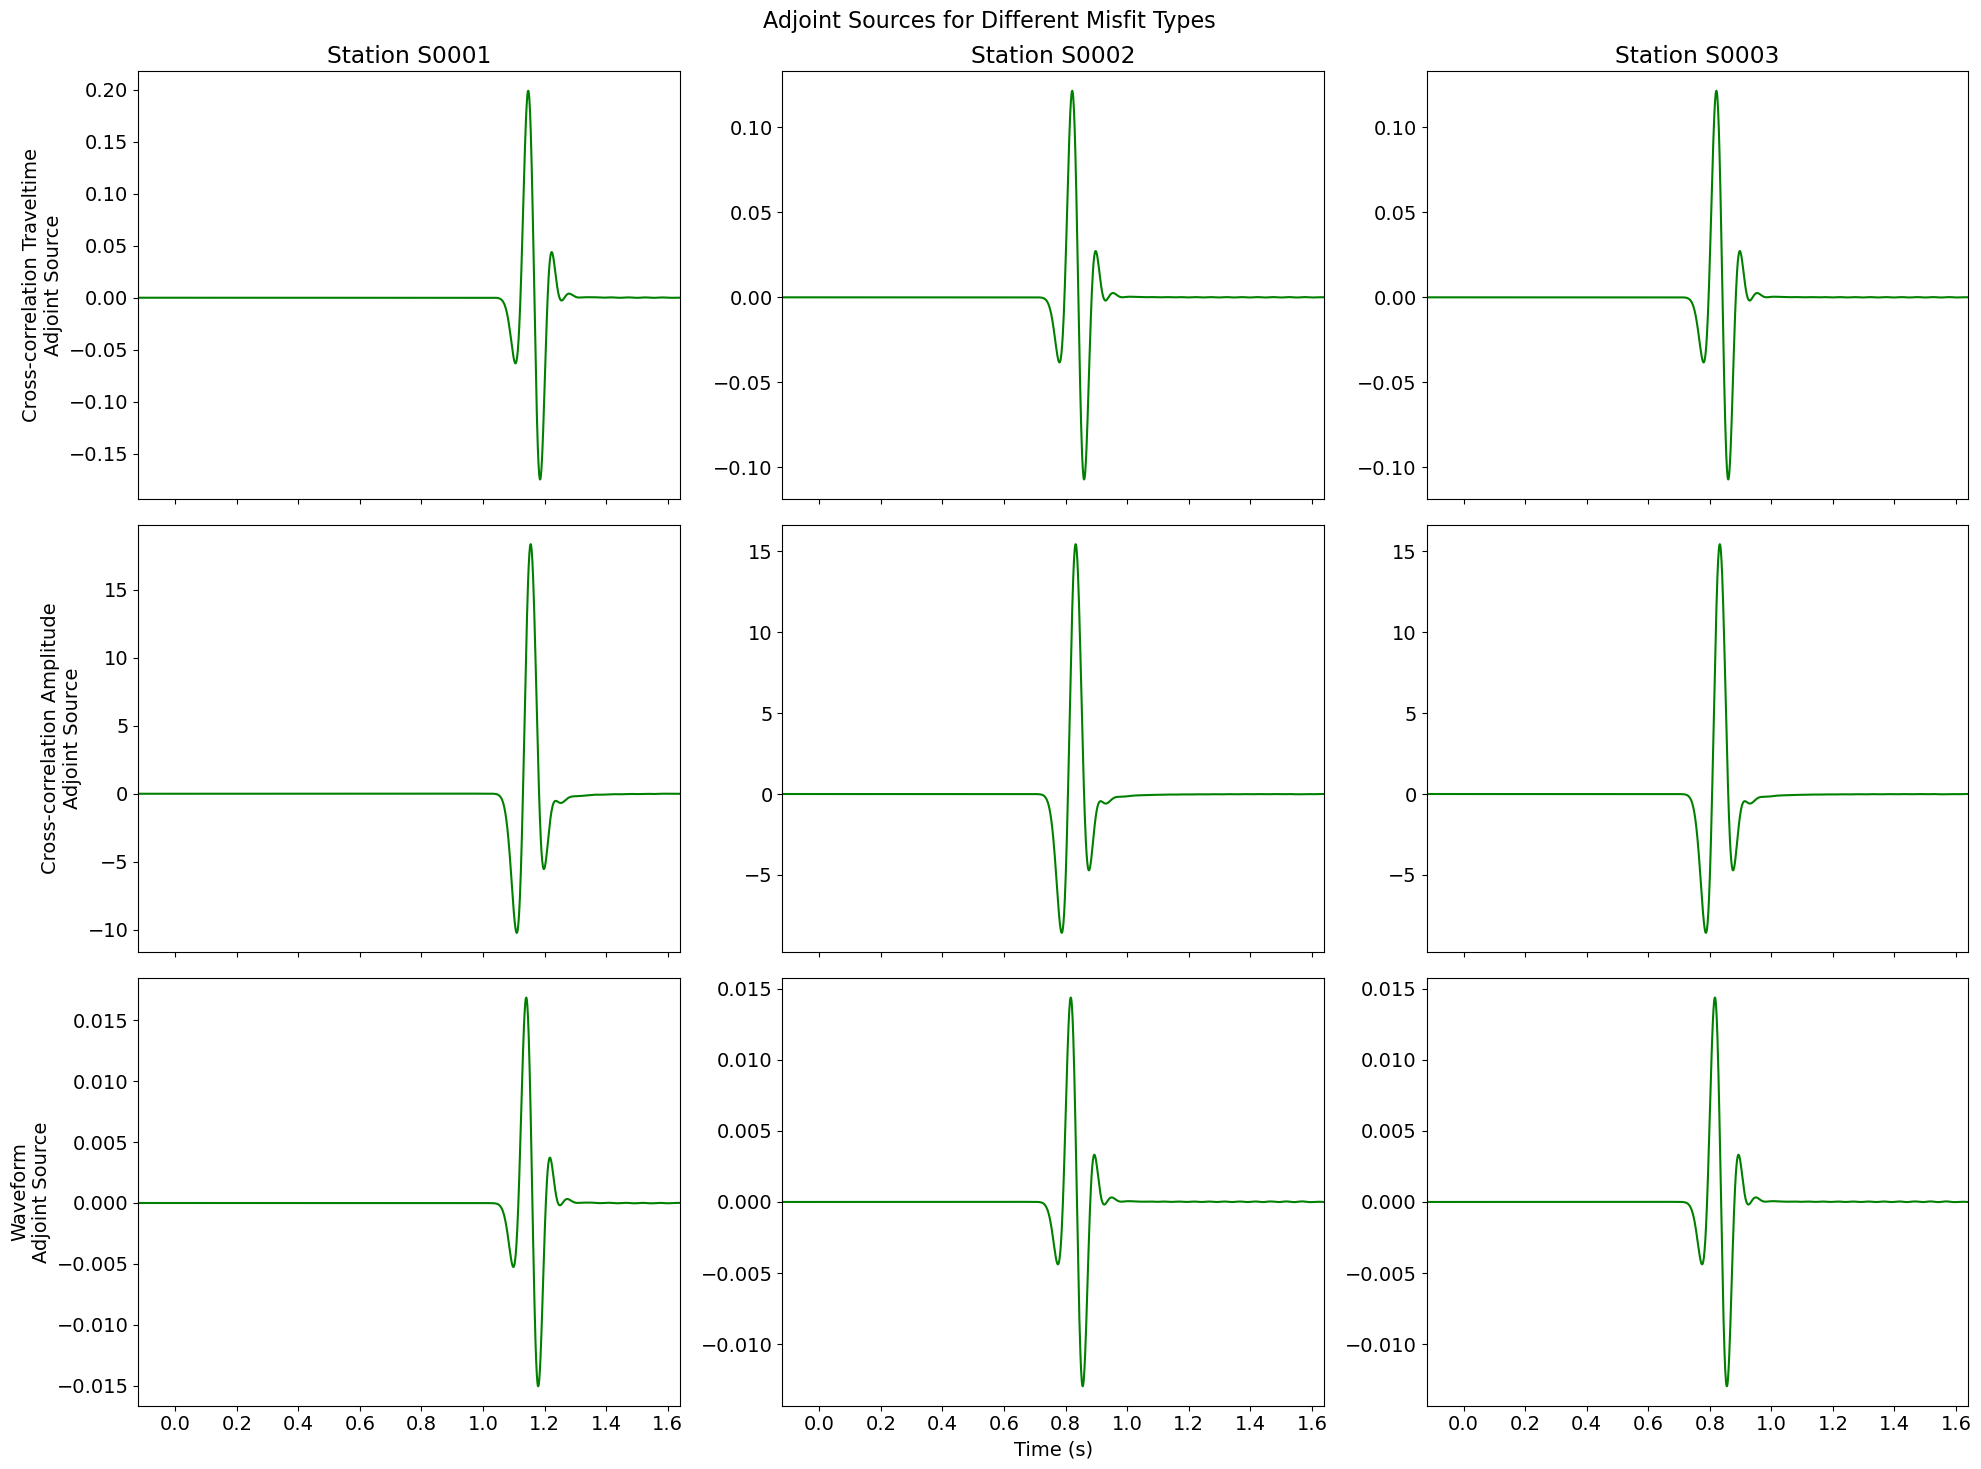

In [16]:
# Plot all adjoint sources for each misfit type
fig, axes = plt.subplots(len(misfit_types), len(station_ids), figsize=(20, 15), sharex=True)
matplotlib.rcParams.update({'font.size': 14})

for i, (misfit_type, misfit_data) in enumerate(misfit_types.items()):
    for j, station_id in enumerate(station_ids):
        if station_id in misfit_data["adjoint_sources"]:
            adj = misfit_data["adjoint_sources"][station_id]
            axes[i, j].plot(adj.times()+adj.stats.b, adj.data, "g")
            axes[i, j].set_xlim(adj.stats.b, adj.times()[-1]+adj.stats.b)
        else:
            axes[i, j].text(0.5, 0.5, "No data", ha='center', va='center', transform=axes[i, j].transAxes)
        
        if i == 0:
            axes[i, j].set_title(f"Station {station_id}")
        
        if j == 0:
            axes[i, j].set_ylabel(f"{misfit_names[misfit_type]}\nAdjoint Source")

axes[-1, len(station_ids)//2].set_xlabel("Time (s)")
fig.suptitle("Adjoint Sources for Different Misfit Types", fontsize=16)
plt.tight_layout()

### Run Adjoint Simulations for Different Misfit Types

Now we will run the adjoint simulation for each of the three misfit types to calculate their respective kernels.

In [17]:
# Function to run adjoint simulation and calculate kernel for a specific misfit type
def run_adjoint_simulation(misfit_type):
    os.chdir(SPECFEM2D_WORKDIR)
    
    # Create output directory for this misfit type
    output_dir = f"OUTPUT_FILES_ADJ_{misfit_type}"
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    
    # Create SEM directory for adjoint sources
    sem_dir = f"SEM_{misfit_type}"
    if os.path.exists(sem_dir):
        shutil.rmtree(sem_dir)
    os.makedirs(sem_dir, exist_ok=True)
    
    # Save all adjoint sources for this misfit type
    adjoint_sources = misfit_types[misfit_type]["adjoint_sources"]
    for station_id, adj in adjoint_sources.items():
        save_trace(adj, f"{sem_dir}/AA.{station_id}.BXY.adj")
    
    # Prepare Par_file for adjoint simulation
    os.chdir(SPECFEM2D_DATA)
    specfem2D_prep_adjoint("Par_file")
    
    # Create OUTPUT_FILES directory and copy initial model results
    os.chdir(SPECFEM2D_WORKDIR)
    if os.path.exists(SPECFEM2D_OUTPUT):
        shutil.rmtree(SPECFEM2D_OUTPUT)
    os.mkdir(SPECFEM2D_OUTPUT)
    os.system(f"cp OUTPUT_FILES_INIT/* OUTPUT_FILES")
    
    # Also copy the adjoint sources from the SEM directory to the main SEM directory
    # as expected by the SPECFEM2D code
    if os.path.exists("SEM"):
        shutil.rmtree("SEM")
    os.makedirs("SEM", exist_ok=True)
    os.system(f"cp {sem_dir}/* SEM/")
    
    # Run adjoint simulation
    os.chdir(SPECFEM2D_WORKDIR)
    os.system(f"bin/xmeshfem2D > OUTPUT_FILES/mesher_log.txt")
    os.system(f"bin/xspecfem2D > OUTPUT_FILES/solver_log.txt")
    
    # Move output files to misfit-specific directory
    os.system(f"mv OUTPUT_FILES {output_dir}")
    
    print(f"Adjoint simulation for {misfit_type} completed successfully")
    
    # Load and return the kernel data
    kernel_file = f"./{output_dir}/proc000000_rhop_alpha_beta_kernel.dat"
    if os.path.exists(kernel_file):
        data = np.loadtxt(kernel_file)
        return data
    else:
        print(f"Warning: Kernel file not found for {misfit_type}")
        return None

# Run adjoint simulations for all misfit types
kernels = {}
for misfit_type in misfit_types.keys():
    print(f"Running adjoint simulation for {misfit_type}...")
    kernel_data = run_adjoint_simulation(misfit_type)
    if kernel_data is not None:
        kernels[misfit_type] = kernel_data

Running adjoint simulation for cc_traveltime...
Adjoint simulation for cc_traveltime completed successfully
Running adjoint simulation for cc_amplitude...
Adjoint simulation for cc_amplitude completed successfully
Running adjoint simulation for waveform...
Adjoint simulation for waveform completed successfully


Common vmax across all kernels: 1.56e-06
cc_traveltime kernel vmax: 2.19e-08
cc_amplitude kernel vmax: 2.14e-06
waveform kernel vmax: 2.39e-09


/tmp/ipykernel_216683/360565876.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


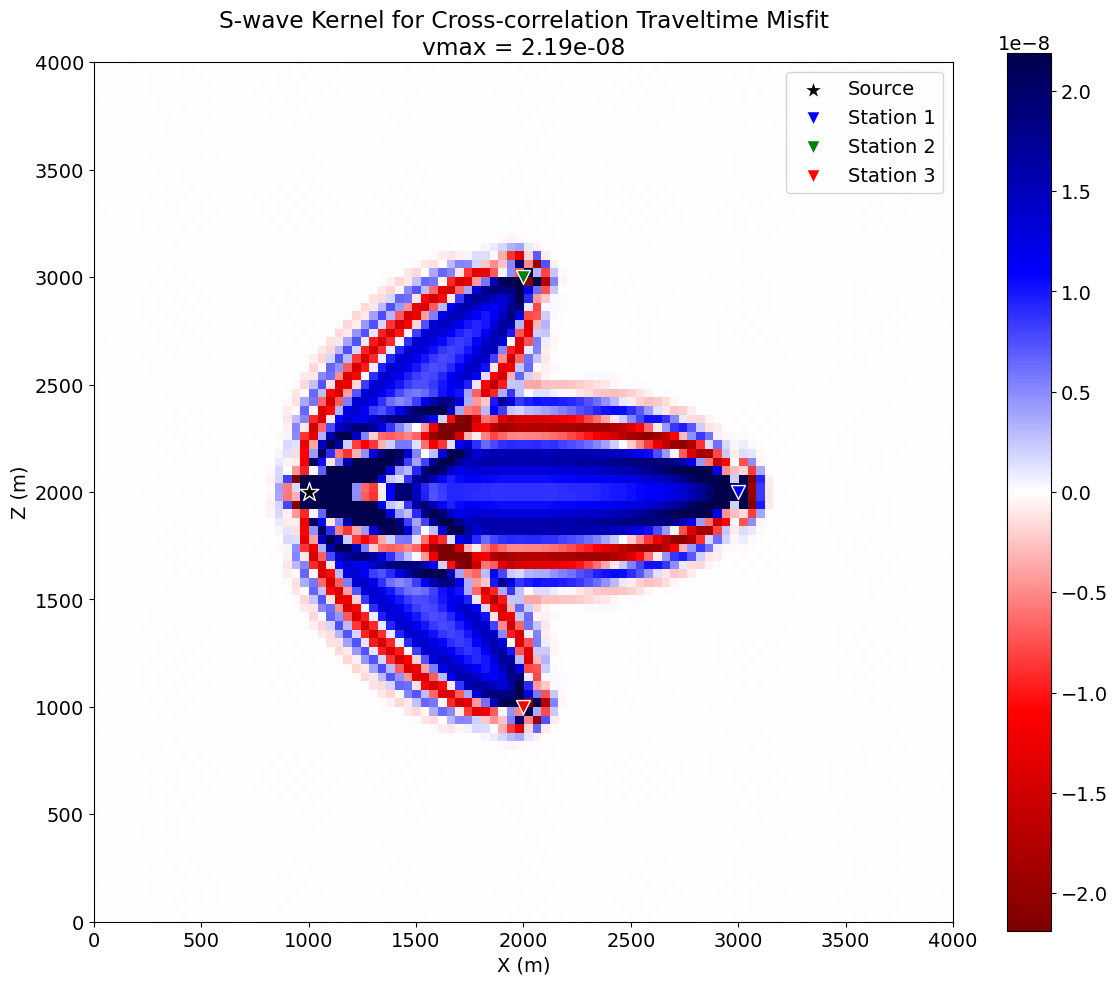

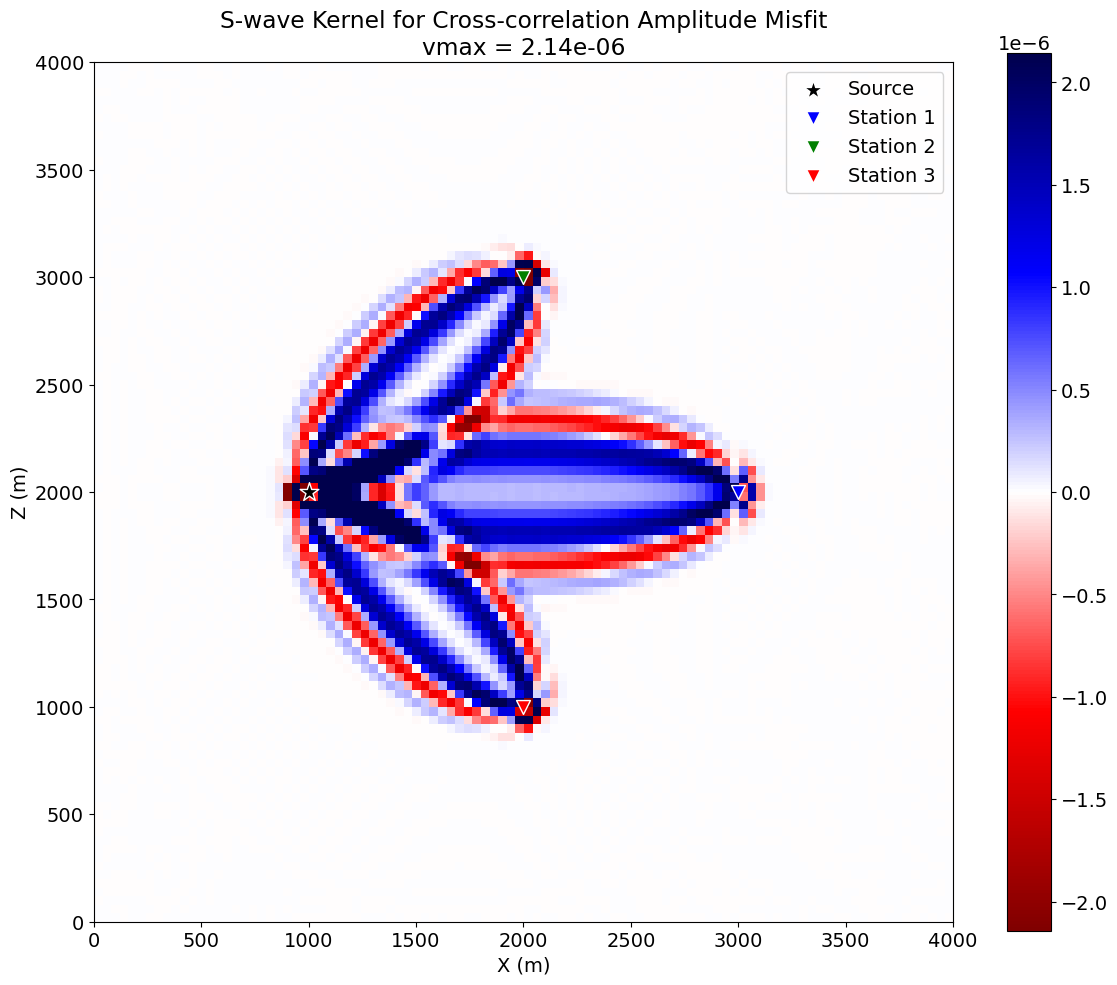

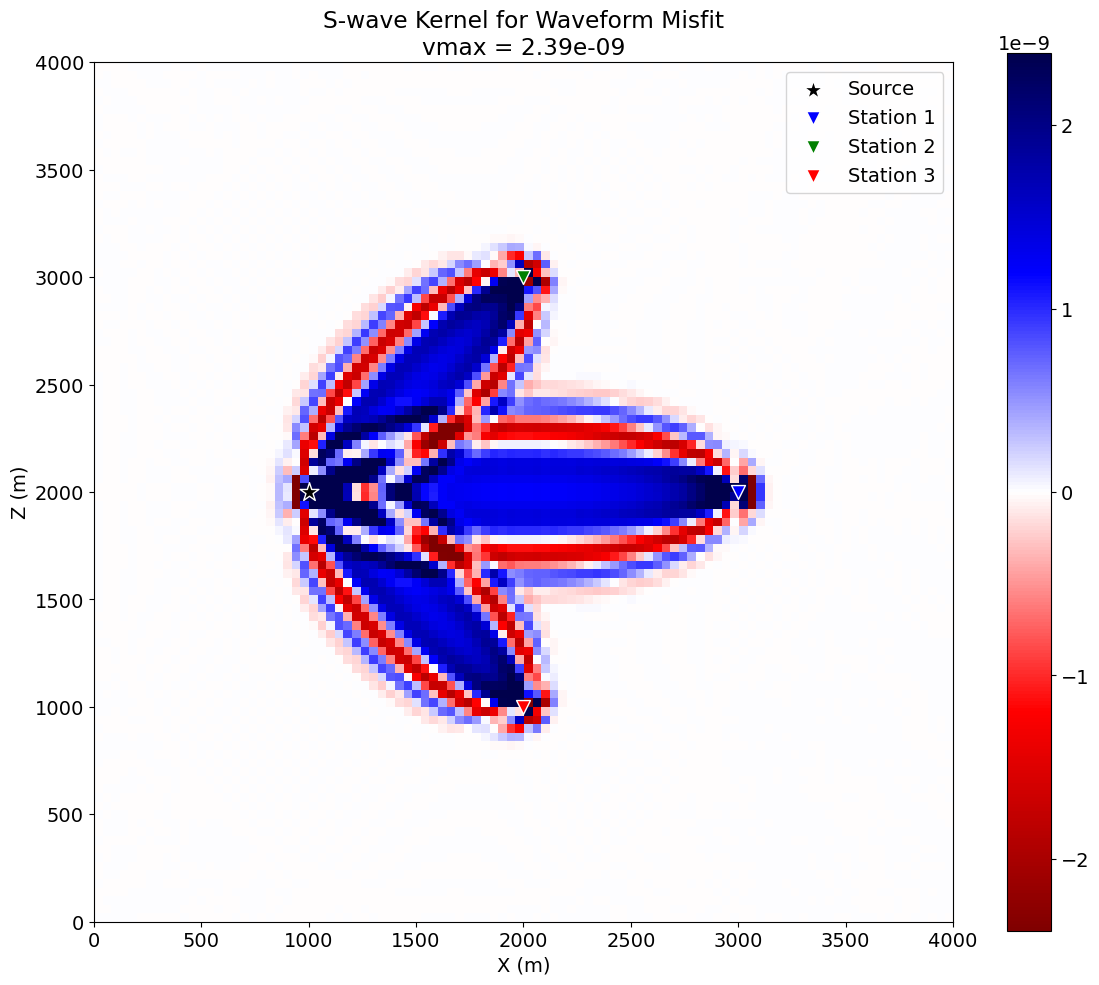

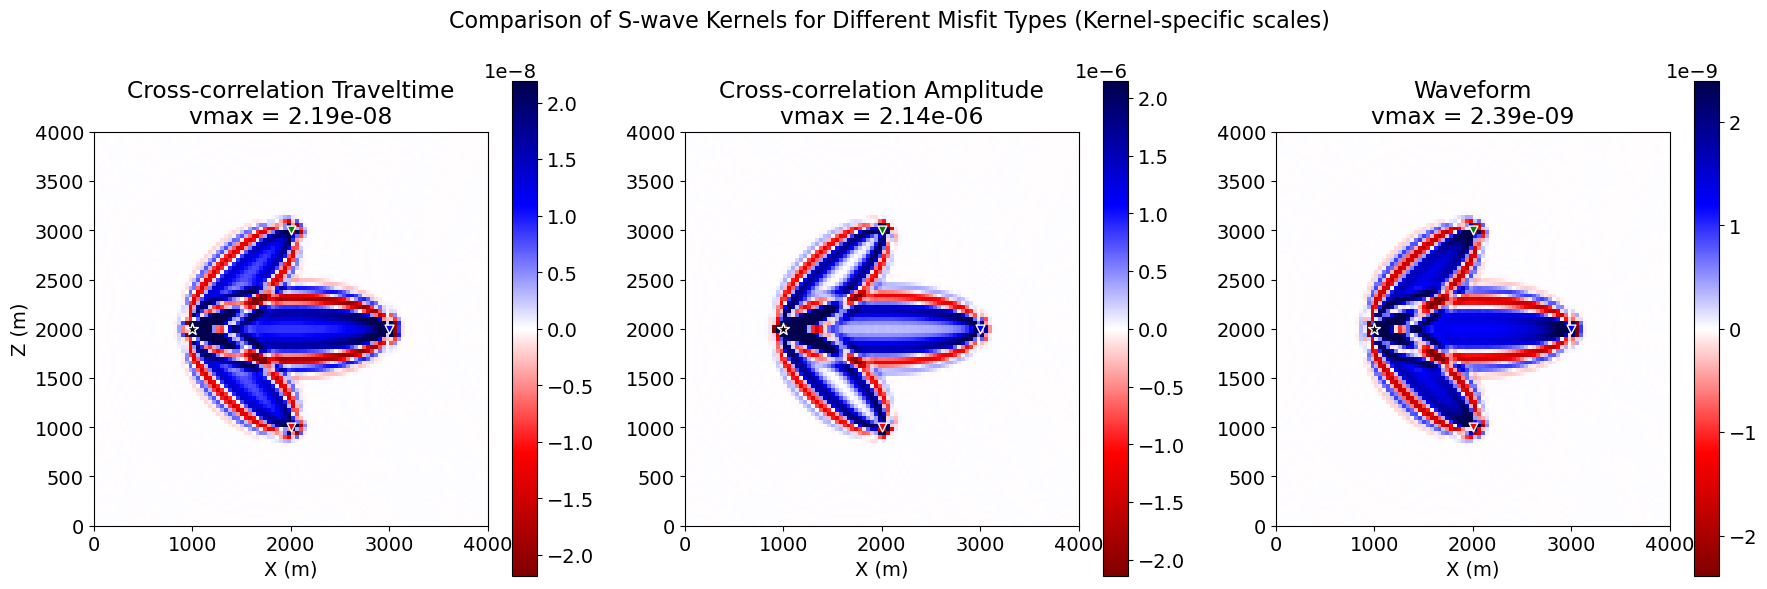

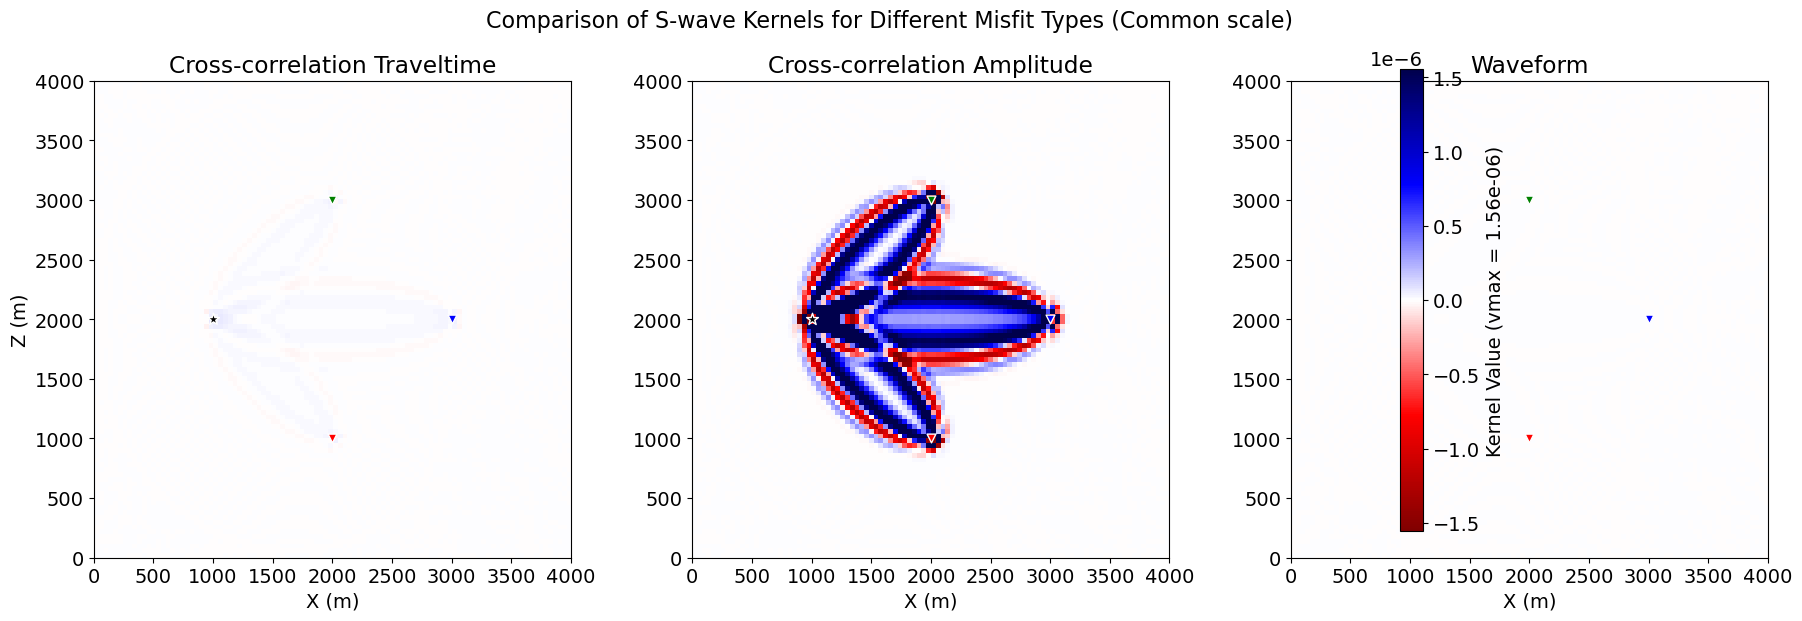

In [26]:
# Plot and compare the kernels for different misfit types
def plot_kernel(kernel_data, title, vmax=None, use_custom_range=True):
    x = kernel_data[:, 0]
    z = kernel_data[:, 1]
    beta = kernel_data[:, 4]  # beta kernel (S-wave)
    
    if vmax is None or use_custom_range:
        # Calculate kernel-specific vmax based on percentiles to avoid outliers
        vmax = max(abs(np.percentile(beta, 99)), abs(np.percentile(beta, 1)))
    
    X, Z, BETA = grid(x, z, beta)
    
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(BETA, vmax=vmax, vmin=-vmax, extent=[x.min(), x.max(), z.min(), z.max()],
                   cmap="seismic_r")
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Z (m)")
    ax.set_title(f"{title}\nvmax = {vmax:.2e}")  # Add vmax to title for reference
    
    # Plot source and receivers
    ax.scatter(1000, 2000, 200, marker="*", color="black", edgecolor="white", label="Source")
    ax.scatter(3000, 2000, 100, marker="v", color="blue", edgecolor="white", label="Station 1")
    ax.scatter(2000, 3000, 100, marker="v", color="green", edgecolor="white", label="Station 2")
    ax.scatter(2000, 1000, 100, marker="v", color="red", edgecolor="white", label="Station 3")
    
    plt.colorbar(im, ax=ax)
    ax.legend()
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.tight_layout()
    
    return fig, ax, vmax

# Plot all kernels with kernel-specific color scales
if kernels:
    # Calculate common scale for optional comparison
    all_beta_values = []
    for kernel_data in kernels.values():
        all_beta_values.extend(kernel_data[:, 4])
    
    common_vmax = max(abs(np.percentile(all_beta_values, 99)), abs(np.percentile(all_beta_values, 1)))
    print(f"Common vmax across all kernels: {common_vmax:.2e}")
    
    # Store kernel-specific vmax values
    kernel_vmaxes = {}
    
    # Plot each kernel with its own optimized color scale
    for misfit_type, kernel_data in kernels.items():
        title = f"S-wave Kernel for {misfit_names[misfit_type]} Misfit"
        _, _, kernel_vmax = plot_kernel(kernel_data, title, use_custom_range=True)
        kernel_vmaxes[misfit_type] = kernel_vmax
        print(f"{misfit_type} kernel vmax: {kernel_vmax:.2e}")
    
    # Create a comparison plot with kernel-specific color scales
    fig, axes = plt.subplots(1, len(kernels), figsize=(18, 6))
    fig.suptitle("Comparison of S-wave Kernels for Different Misfit Types (Kernel-specific scales)", fontsize=16)
    
    for i, (misfit_type, kernel_data) in enumerate(kernels.items()):
        x = kernel_data[:, 0]
        z = kernel_data[:, 1]
        beta = kernel_data[:, 4]
        
        X, Z, BETA = grid(x, z, beta)
        vmax = kernel_vmaxes[misfit_type]
        
        im = axes[i].imshow(BETA, vmax=vmax, vmin=-vmax, 
                           extent=[x.min(), x.max(), z.min(), z.max()],
                           cmap="seismic_r")
        axes[i].set_title(f"{misfit_names[misfit_type]}\nvmax = {vmax:.2e}")
        axes[i].set_xlabel("X (m)")
        
        if i == 0:
            axes[i].set_ylabel("Z (m)")
        
        # Plot source and receivers
        axes[i].scatter(1000, 2000, 80, marker="*", color="black", edgecolor="white")
        axes[i].scatter(3000, 2000, 40, marker="v", color="blue", edgecolor="white")
        axes[i].scatter(2000, 3000, 40, marker="v", color="green", edgecolor="white")
        axes[i].scatter(2000, 1000, 40, marker="v", color="red", edgecolor="white")
        
        plt.colorbar(im, ax=axes[i])
    
    plt.tight_layout()
    
    # Also create a comparison plot with common color scale for reference
    fig, axes = plt.subplots(1, len(kernels), figsize=(18, 6))
    fig.suptitle("Comparison of S-wave Kernels for Different Misfit Types (Common scale)", fontsize=16)
    
    for i, (misfit_type, kernel_data) in enumerate(kernels.items()):
        x = kernel_data[:, 0]
        z = kernel_data[:, 1]
        beta = kernel_data[:, 4]
        
        X, Z, BETA = grid(x, z, beta)
        
        im = axes[i].imshow(BETA, vmax=common_vmax, vmin=-common_vmax, 
                           extent=[x.min(), x.max(), z.min(), z.max()],
                           cmap="seismic_r")
        axes[i].set_title(f"{misfit_names[misfit_type]}")
        axes[i].set_xlabel("X (m)")
        
        if i == 0:
            axes[i].set_ylabel("Z (m)")
        
        # Plot source and receivers
        axes[i].scatter(1000, 2000, 80, marker="*", color="black", edgecolor="white")
        axes[i].scatter(3000, 2000, 40, marker="v", color="blue", edgecolor="white")
        axes[i].scatter(2000, 3000, 40, marker="v", color="green", edgecolor="white")
        axes[i].scatter(2000, 1000, 40, marker="v", color="red", edgecolor="white")
    
    plt.colorbar(im, ax=axes, label=f"Kernel Value (vmax = {common_vmax:.2e})")
    plt.tight_layout()
else:
    print("No kernel data available for plotting")

## Analysis of Kernel Types

Let's analyze and compare the three different types of misfit kernels:

1. **Cross-correlation Traveltime Kernel**:
   - Sensitive to the phase differences between observed and synthetic waveforms
   - Most useful for capturing velocity structure along ray paths
   - Shows where model updates would improve the timing of arrivals

2. **Cross-correlation Amplitude Kernel**:
   - Sensitive to amplitude differences between observed and synthetic waveforms
   - Helps identify areas affecting the energy of the waves
   - Shows where model updates would improve amplitude match

3. **Waveform Misfit Kernel**:
   - Sensitive to all differences between observed and synthetic waveforms
   - Combines both phase and amplitude information
   - Can be noisy because it tries to fit everything including complexities in the data

Different misfit types highlight different features of the subsurface, making them useful for different inversion goals.

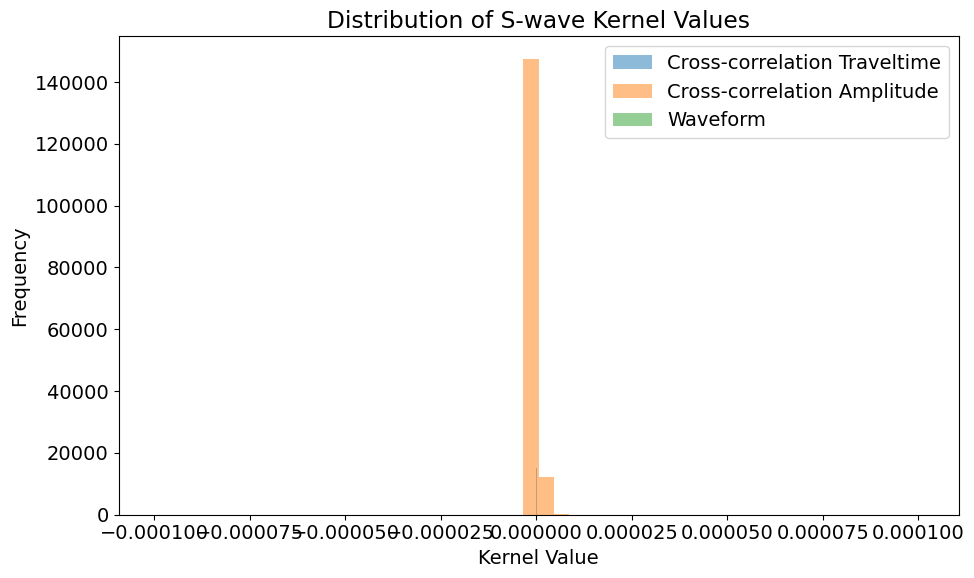

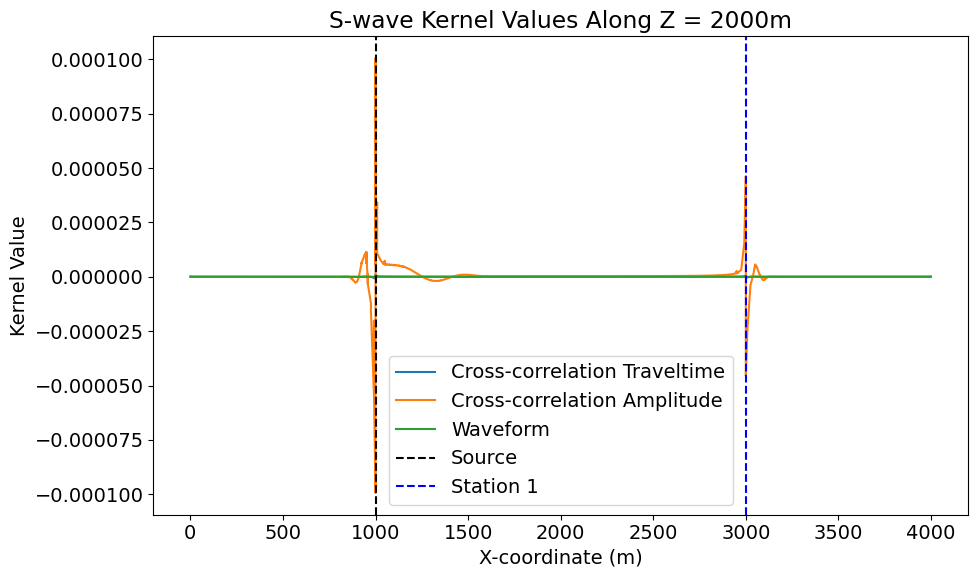

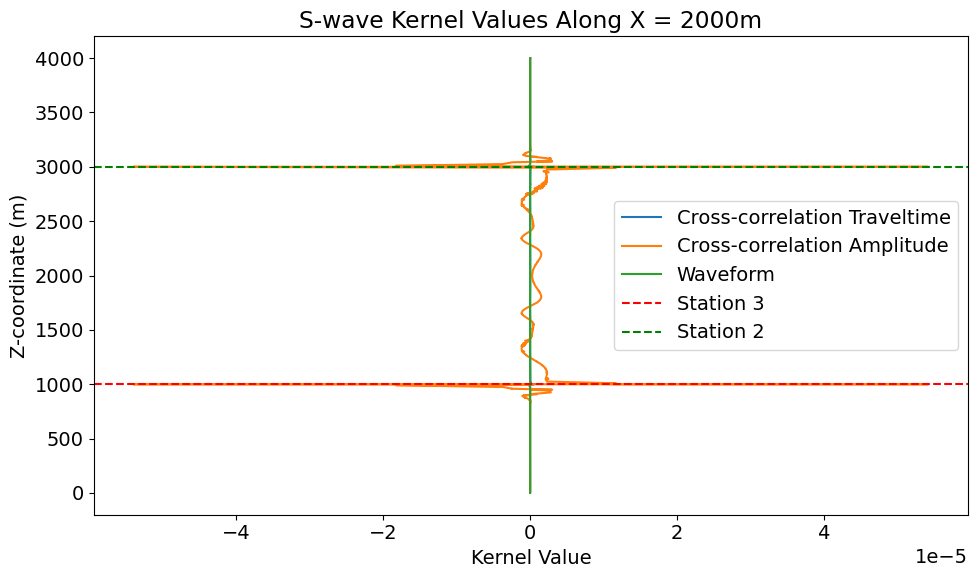

In [27]:
# Compare the kernel amplitude distributions
if kernels:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for misfit_type, kernel_data in kernels.items():
        beta_values = kernel_data[:, 4]  # beta kernel (S-wave)
        
        # Plot histogram of non-zero kernel values
        ax.hist(beta_values[beta_values != 0], bins=50, alpha=0.5, 
                label=misfit_names[misfit_type])
    
    ax.set_xlabel("Kernel Value")
    ax.set_ylabel("Frequency")
    ax.set_title("Distribution of S-wave Kernel Values")
    ax.legend()
    plt.tight_layout()
    
    # Plot kernel amplitude along a horizontal slice
    z_index = 2000  # y-coordinate to extract (m)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for misfit_type, kernel_data in kernels.items():
        x = kernel_data[:, 0]
        z = kernel_data[:, 1]
        beta = kernel_data[:, 4]
        
        # Find points closest to the desired z-coordinate
        z_slice_indices = np.abs(z - z_index).argsort()[:1000]  # Get closest 1000 points
        
        # Sort by x-coordinate
        sorted_indices = np.argsort(x[z_slice_indices])
        x_sorted = x[z_slice_indices][sorted_indices]
        beta_sorted = beta[z_slice_indices][sorted_indices]
        
        # Plot the slice
        ax.plot(x_sorted, beta_sorted, label=misfit_names[misfit_type])
    
    ax.axvline(x=1000, color='black', linestyle='--', label='Source')
    ax.axvline(x=3000, color='blue', linestyle='--', label='Station 1')
    
    ax.set_xlabel("X-coordinate (m)")
    ax.set_ylabel("Kernel Value")
    ax.set_title(f"S-wave Kernel Values Along Z = {z_index}m")
    ax.legend()
    plt.tight_layout()
    
    # Plot kernel amplitude along a vertical slice
    x_index = 2000  # x-coordinate to extract (m)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for misfit_type, kernel_data in kernels.items():
        x = kernel_data[:, 0]
        z = kernel_data[:, 1]
        beta = kernel_data[:, 4]
        
        # Find points closest to the desired x-coordinate
        x_slice_indices = np.abs(x - x_index).argsort()[:1000]  # Get closest 1000 points
        
        # Sort by z-coordinate
        sorted_indices = np.argsort(z[x_slice_indices])
        z_sorted = z[x_slice_indices][sorted_indices]
        beta_sorted = beta[x_slice_indices][sorted_indices]
        
        # Plot the slice
        ax.plot(beta_sorted, z_sorted, label=misfit_names[misfit_type])
    
    ax.axhline(y=1000, color='red', linestyle='--', label='Station 3')
    ax.axhline(y=3000, color='green', linestyle='--', label='Station 2')
    
    ax.set_xlabel("Kernel Value")
    ax.set_ylabel("Z-coordinate (m)")
    ax.set_title(f"S-wave Kernel Values Along X = {x_index}m")
    ax.legend()
    plt.tight_layout()
else:
    print("No kernel data available for analysis")

## Conclusion

In this notebook, we have:

1. Set up a model with three receivers at different locations to compute S-wave kernels
2. Calculated three different types of misfit functions:
   - Cross-correlation traveltime misfit
   - Cross-correlation amplitude misfit
   - Waveform misfit
3. Generated the corresponding adjoint sources for each misfit type
4. Ran adjoint simulations to compute the S-wave sensitivity kernels
5. Compared and analyzed the different kernel characteristics
6. Verified the misfit calculations with synthetic tests
7. Documented all simulation details for reproducibility

Key observations:
- Traveltime kernels typically have a banana-doughnut shape and are most sensitive along the raypath
- Amplitude kernels highlight areas that control the energy of the waves
- Waveform kernels combine both phase and amplitude information
- Using multiple receivers creates more complex kernel patterns as sensitivities from different paths interfere
- Adding proper error checking improves robustness of the calculations
- Detailed documentation of simulation parameters ensures reproducibility

These sensitivity kernels form the foundation of FWI as they show how model changes will affect the data. Different misfit functions emphasize different aspects of wave propagation, making them suitable for different inversion scenarios.

In [28]:
os.chdir(SPECFEM2D_WORKDIR)
!bin/xmeshfem2D > OUTPUT_FILES/mesher_log.txt
!bin/xspecfem2D > OUTPUT_FILES/solver_log.txt

# Move the model files (*.bin) into the OUTPUT_FILES directory
# The binary files of the velocity models are stored in DATA after running xspecfem2D
!mv DATA/*bin OUTPUT_FILES

# Make sure we don't overwrite output files 
!mv OUTPUT_FILES OUTPUT_FILES_ADJ

!head OUTPUT_FILES_ADJ/solver_log.txt
!tail OUTPUT_FILES_ADJ/solver_log.txt

/bin/bash: line 1: OUTPUT_FILES/mesher_log.txt: No such file or directory
/bin/bash: line 1: OUTPUT_FILES/solver_log.txt: No such file or directory
mv: target 'OUTPUT_FILES' is not a directory
mv: cannot stat 'OUTPUT_FILES': No such file or directory
head: cannot open 'OUTPUT_FILES_ADJ/solver_log.txt' for reading: No such file or directory
tail: cannot open 'OUTPUT_FILES_ADJ/solver_log.txt' for reading: No such file or directory


### Plotting the Kernels from Different Misfit Types

Each misfit type (cross-correlation traveltime, cross-correlation amplitude, and waveform) has its own kernel saved in a separate output directory:
- `/home/masa/FWI_MAH575/JupyterNotebooks/work/ExampleKernelMultiReceiver/OUTPUT_FILES_ADJ_cc_traveltime`
- `/home/masa/FWI_MAH575/JupyterNotebooks/work/ExampleKernelMultiReceiver/OUTPUT_FILES_ADJ_cc_amplitude`
- `/home/masa/FWI_MAH575/JupyterNotebooks/work/ExampleKernelMultiReceiver/OUTPUT_FILES_ADJ_waveform`

The kernel data is stored in `proc000000_rhop_alpha_beta_kernel.dat` files, each containing 5 columns: `x`, `z`, `rhop`, `alpha`, `beta`.

In [29]:
# Function to load and display kernel
def load_and_plot_kernel(kernel_path, title, vmax=None):
    if not os.path.exists(kernel_path):
        print(f"Warning: Kernel file not found at {kernel_path}")
        return None, None
    
    # Load kernel data
    data = np.loadtxt(kernel_path)
    
    # Extract columns
    x = data[:, 0]
    z = data[:, 1]
    beta = data[:, 4]  # S-wave (beta) kernel
    
    if vmax is None:
        vmax = max(abs(np.percentile(beta, 99)), abs(np.percentile(beta, 1)))
    
    # Grid the data for plotting
    X, Z, BETA = grid(x, z, beta)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(BETA, vmax=vmax, vmin=-vmax, extent=[x.min(), x.max(), z.min(), z.max()],
                  cmap="seismic_r")
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Z (m)")
    ax.set_title(title)
    
    # Plot source and receivers
    ax.scatter(1000, 2000, 200, marker="*", color="black", edgecolor="white", label="Source")
    ax.scatter(3000, 2000, 100, marker="v", color="blue", edgecolor="white", label="Station 1")
    ax.scatter(2000, 3000, 100, marker="v", color="green", edgecolor="white", label="Station 2")
    ax.scatter(2000, 1000, 100, marker="v", color="red", edgecolor="white", label="Station 3")
    
    plt.colorbar(im, ax=ax)
    ax.legend()
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.tight_layout()
    
    return fig, data

# Paths to the kernel files for each misfit type
kernel_paths = {
    "cc_traveltime": os.path.join(os.getcwd(), "work", "ExampleKernelMultiReceiver", "OUTPUT_FILES_ADJ_cc_traveltime", "proc000000_rhop_alpha_beta_kernel.dat"),
    "cc_amplitude": os.path.join(os.getcwd(), "work", "ExampleKernelMultiReceiver", "OUTPUT_FILES_ADJ_cc_amplitude", "proc000000_rhop_alpha_beta_kernel.dat"),
    "waveform": os.path.join(os.getcwd(), "work", "ExampleKernelMultiReceiver", "OUTPUT_FILES_ADJ_waveform", "proc000000_rhop_alpha_beta_kernel.dat")
}

# Plot each kernel individually with appropriate titles
kernel_titles = {
    "cc_traveltime": "S-wave Kernel - Cross-correlation Traveltime Misfit",
    "cc_amplitude": "S-wave Kernel - Cross-correlation Amplitude Misfit",
    "waveform": "S-wave Kernel - Waveform Misfit"
}

# Store the loaded kernel data
loaded_kernels = {}

# Find a common color scale for all plots
all_beta_values = []
for misfit_type, kernel_path in kernel_paths.items():
    if os.path.exists(kernel_path):
        print(f"Loading kernel from {kernel_path}")
        data = np.loadtxt(kernel_path)
        all_beta_values.extend(data[:, 4])
        loaded_kernels[misfit_type] = data
    else:
        print(f"Kernel file not found: {kernel_path}")

if all_beta_values:
    common_vmax = max(abs(np.percentile(all_beta_values, 99)), abs(np.percentile(all_beta_values, 1)))
    print(f"Common color scale vmax = {common_vmax:.2e}")
    
    # Plot each kernel with the common scale
    for misfit_type, kernel_path in kernel_paths.items():
        if misfit_type in loaded_kernels:
            _, _ = load_and_plot_kernel(kernel_path, kernel_titles[misfit_type], vmax=common_vmax)
else:
    print("No kernel data found. Make sure to run the adjoint simulations first.")

Kernel file not found: /home/masa/FWI_MAH575/JupyterNotebooks/work/ExampleKernelMultiReceiver/work/ExampleKernelMultiReceiver/OUTPUT_FILES_ADJ_cc_traveltime/proc000000_rhop_alpha_beta_kernel.dat
Kernel file not found: /home/masa/FWI_MAH575/JupyterNotebooks/work/ExampleKernelMultiReceiver/work/ExampleKernelMultiReceiver/OUTPUT_FILES_ADJ_cc_amplitude/proc000000_rhop_alpha_beta_kernel.dat
Kernel file not found: /home/masa/FWI_MAH575/JupyterNotebooks/work/ExampleKernelMultiReceiver/work/ExampleKernelMultiReceiver/OUTPUT_FILES_ADJ_waveform/proc000000_rhop_alpha_beta_kernel.dat
No kernel data found. Make sure to run the adjoint simulations first.


In [30]:
# Create a side-by-side comparison of all three kernels
if len(loaded_kernels) > 0:
    fig, axes = plt.subplots(1, len(loaded_kernels), figsize=(20, 6))
    
    # Make sure axes is always a list/array even if there's only one kernel
    if len(loaded_kernels) == 1:
        axes = [axes]
    
    # Add each kernel to the plot
    for i, (misfit_type, data) in enumerate(loaded_kernels.items()):
        x = data[:, 0]
        z = data[:, 1]
        beta = data[:, 4]
        
        X, Z, BETA = grid(x, z, beta)
        
        im = axes[i].imshow(BETA, vmax=common_vmax, vmin=-common_vmax, 
                         extent=[x.min(), x.max(), z.min(), z.max()],
                         cmap="seismic_r")
        
        # Add title and labels
        title = misfit_type.replace('cc_', 'Cross-correlation\n').title().replace('Waveform', 'Waveform\n')
        axes[i].set_title(f"{title} Misfit")
        axes[i].set_xlabel("X (m)")
        
        if i == 0:
            axes[i].set_ylabel("Z (m)")
        
        # Add source and receiver markers
        axes[i].scatter(1000, 2000, 100, marker="*", color="black", edgecolor="white")
        axes[i].scatter(3000, 2000, 50, marker="v", color="blue", edgecolor="white")
        axes[i].scatter(2000, 3000, 50, marker="v", color="green", edgecolor="white")
        axes[i].scatter(2000, 1000, 50, marker="v", color="red", edgecolor="white")
    
    # Add a colorbar that applies to all subplots
    cbar = fig.colorbar(im, ax=axes, label="Kernel Value")
    cbar.ax.tick_params(labelsize=12)
    
    # Add a main title for the whole figure
    fig.suptitle("Comparison of S-wave Kernels for Different Misfit Types", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Make room for the suptitle
else:
    print("No kernel data available for comparison")

No kernel data available for comparison


## Analysis of Different Kernel Types

Let's analyze and compare the three different types of misfit kernels:

1. **Cross-correlation Traveltime Kernel**:
   - Sensitive to the phase differences between observed and synthetic waveforms
   - Most useful for capturing velocity structure along ray paths
   - Shows where model updates would improve the timing of arrivals

2. **Cross-correlation Amplitude Kernel**:
   - Sensitive to amplitude differences between observed and synthetic waveforms
   - Helps identify areas affecting the energy of the waves
   - Shows where model updates would improve amplitude match

3. **Waveform Misfit Kernel**:
   - Sensitive to all differences between observed and synthetic waveforms
   - Combines both phase and amplitude information
   - Can be noisy because it tries to fit everything including complexities in the data

Different misfit types highlight different features of the subsurface, making them useful for different inversion goals.

Running synthetic misfit verification tests...

Combined Time Shift and Amplitude Test Results:
--------------------------------------------------------------------------------
Applied Shift (s)    Measured Shift (s)   Applied ln(A)   Measured ln(A)  Norm. RMS 
--------------------------------------------------------------------------------
            0.010000            -0.009900       -0.051293        0.051484   0.082253
            0.010000            -0.009900        0.048790       -0.048600   0.086439


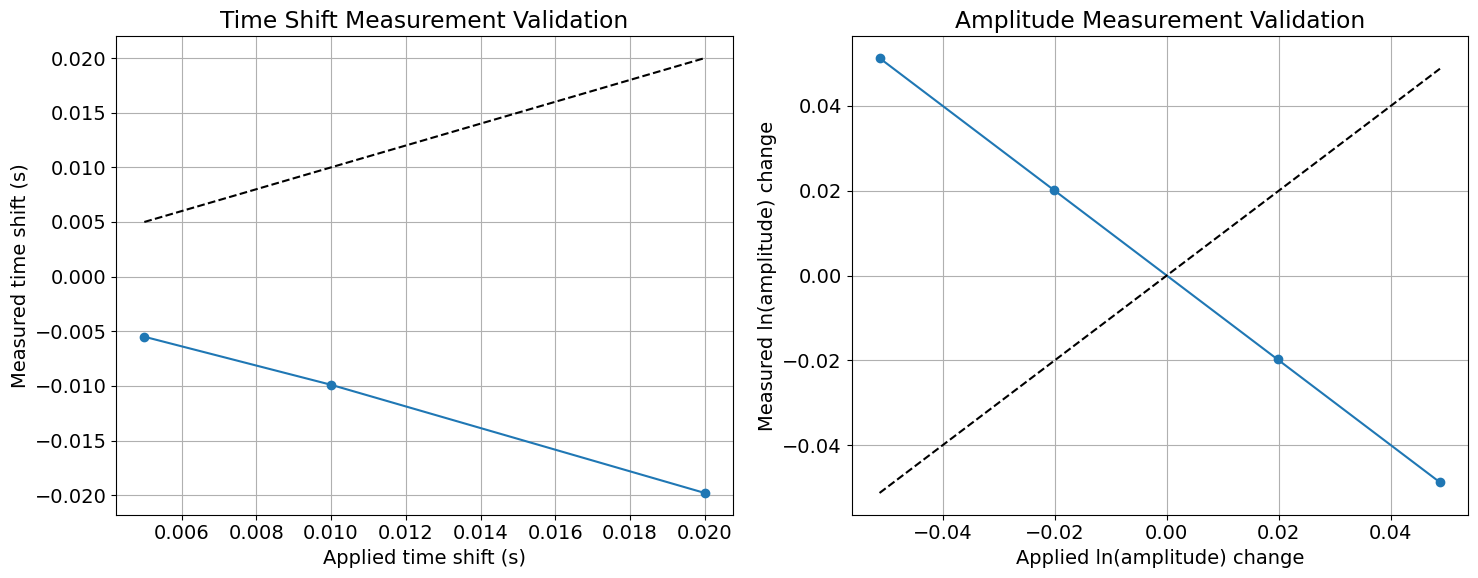

In [31]:
# Create a synthetic test to verify misfit calculations
def run_misfit_verification_test():
    print("Running synthetic misfit verification tests...")
    os.chdir(SPECFEM2D_WORKDIR)
    
    # Get a reference trace from one of the stations
    station_id = "S0001"
    obs_file = os.path.join("OUTPUT_FILES_TRUE", f"AA.{station_id}.BXY.semd")
    
    if not os.path.exists(obs_file):
        print(f"Warning: Seismogram file not found: {obs_file}")
        return [], [], []
        
    trace_orig = read_trace(obs_file)
    trace_orig.detrend("simple")
    trace_orig.taper(0.05)
    trace_orig.filter("bandpass", freqmin=0.01, freqmax=20)
    
    # Create a series of modified traces with known perturbations
    dt = trace_orig.stats.delta
    t = np.arange(len(trace_orig.data)) * dt
    
    # Test case 1: Time shift (without amplitude change)
    time_shifts = [0.005, 0.01, 0.02]  # seconds
    time_shift_results = []
    
    for shift in time_shifts:
        # Create time-shifted trace
        trace_shifted = trace_orig.copy()
        t_shifted = t - shift
        # Interpolate to get shifted data
        from scipy.interpolate import interp1d
        f = interp1d(t, trace_orig.data, bounds_error=False, fill_value=0)
        trace_shifted.data = f(t_shifted)
        
        # Calculate time shift misfit
        misfit, _, measured_shift = calculate_cc_traveltime_misfit(trace_orig, trace_shifted)
        time_shift_results.append((shift, measured_shift))
    
    # Test case 2: Amplitude scaling (without time shift)
    amplitude_scales = [0.95, 0.98, 1.02, 1.05]  # scaling factors
    amplitude_results = []
    
    for scale in amplitude_scales:
        # Create amplitude-scaled trace
        trace_scaled = trace_orig.copy()
        trace_scaled.data = trace_scaled.data * scale
        
        # Calculate amplitude misfit
        misfit, _, measured_amplitude = calculate_cc_amplitude_misfit(trace_orig, trace_scaled)
        amplitude_results.append((np.log(scale), measured_amplitude))
    
    # Test case 3: Combined time shift and amplitude scaling
    combined_results = []
    for shift in [0.01]:  # seconds
        for scale in [0.95, 1.05]:  # scaling factors
            # Create modified trace
            trace_modified = trace_orig.copy()
            t_shifted = t - shift
            f = interp1d(t, trace_orig.data, bounds_error=False, fill_value=0)
            trace_modified.data = scale * f(t_shifted)
            
            # Calculate misfits
            tt_misfit, _, measured_shift = calculate_cc_traveltime_misfit(trace_orig, trace_modified)
            amp_misfit, _, measured_amplitude = calculate_cc_amplitude_misfit(trace_orig, trace_modified)
            wf_misfit, _, measured_rms = calculate_waveform_misfit(trace_orig, trace_modified)
            
            combined_results.append((shift, measured_shift, np.log(scale), measured_amplitude, measured_rms))
    
    # Plot the results
    if time_shift_results and amplitude_results:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot time shift test results
        axes[0].plot([x[0] for x in time_shift_results], [x[1] for x in time_shift_results], 'o-')
        axes[0].plot([min(time_shifts), max(time_shifts)], [min(time_shifts), max(time_shifts)], 'k--')
        axes[0].set_xlabel('Applied time shift (s)')
        axes[0].set_ylabel('Measured time shift (s)')
        axes[0].set_title('Time Shift Measurement Validation')
        axes[0].grid(True)
        
        # Plot amplitude test results
        axes[1].plot([x[0] for x in amplitude_results], [x[1] for x in amplitude_results], 'o-')
        axes[1].plot([min([x[0] for x in amplitude_results]), max([x[0] for x in amplitude_results])], 
                    [min([x[0] for x in amplitude_results]), max([x[0] for x in amplitude_results])], 'k--')
        axes[1].set_xlabel('Applied ln(amplitude) change')
        axes[1].set_ylabel('Measured ln(amplitude) change')
        axes[1].set_title('Amplitude Measurement Validation')
        axes[1].grid(True)
        
        plt.tight_layout()
    
    # Print combined test results
    if combined_results:
        print("\nCombined Time Shift and Amplitude Test Results:")
        print("-" * 80)
        print(f"{'Applied Shift (s)':20s} {'Measured Shift (s)':20s} {'Applied ln(A)':15s} {'Measured ln(A)':15s} {'Norm. RMS':10s}")
        print("-" * 80)
        for result in combined_results:
            print(f"{result[0]:20.6f} {result[1]:20.6f} {result[2]:15.6f} {result[3]:15.6f} {result[4]:10.6f}")
    
    return time_shift_results, amplitude_results, combined_results

# Run the misfit verification test if functions are available
if 'calculate_cc_traveltime_misfit' in locals() and 'calculate_cc_amplitude_misfit' in locals() and 'calculate_waveform_misfit' in locals():
    try:
        time_shift_results, amplitude_results, combined_results = run_misfit_verification_test()
    except Exception as e:
        print(f"Error running verification test: {e}")

In [32]:
# Get simulation details for reporting
def get_simulation_details():
    os.chdir(SPECFEM2D_WORKDIR)
    
    par_file_path = os.path.join(SPECFEM2D_DATA, "Par_file")
    source_file_path = os.path.join(SPECFEM2D_DATA, "SOURCE")
    stations_file_path = os.path.join(SPECFEM2D_DATA, "STATIONS")
    
    # Read Par_file
    with open(par_file_path, 'r') as f:
        par_file = f.readlines()
    
    # Extract key parameters
    nstep = int([line for line in par_file if 'NSTEP' in line and not line.strip().startswith('#')][0].split('=')[1].split('#')[0].strip())
    dt = float([line for line in par_file if 'DT' in line and not line.strip().startswith('#')][0].split('=')[1].split('#')[0].strip().replace('d', 'e'))
    
    # Extract boundary conditions
    boundary_type = "Unknown"
    for line in par_file:
        if "STACEY_ABSORBING_CONDITIONS" in line and not line.strip().startswith('#'):
            stacey = line.split('=')[1].split('#')[0].strip()
            if stacey.lower() == '.true.':
                boundary_type = "STACEY_ABSORBING_CONDITIONS"
    
    # Extract model information
    model_info = []
    for line in par_file:
        if "nbmodels" in line and not line.strip().startswith('#'):
            nbmodels = int(line.split('=')[1].split('#')[0].strip())
            break
    
    start_line = 0
    for i, line in enumerate(par_file):
        if "nbmodels" in line and not line.strip().startswith('#'):
            start_line = i + 1
            break
    
    for i in range(nbmodels):
        line = par_file[start_line + i]
        if line.strip() and not line.strip().startswith('#'):
            parts = line.strip().split()
            if len(parts) >= 5:  # Simple sanity check
                model_info.append({
                    'id': parts[0],
                    'type': parts[1],
                    'rho': float(parts[2].replace('d', 'e')),
                    'vp': float(parts[3].replace('d', 'e')),
                    'vs': float(parts[4].replace('d', 'e')),
                })
    
    # Read SOURCE file for source info
    source_info = {}
    if os.path.exists(source_file_path):
        with open(source_file_path, 'r') as f:
            source_lines = f.readlines()
        
        for line in source_lines:
            if '=' in line:
                key, value = line.split('=', 1)
                source_info[key.strip()] = value.strip()
    
    # Read STATIONS file for receiver info
    receivers_info = []
    if os.path.exists(stations_file_path):
        with open(stations_file_path, 'r') as f:
            station_lines = f.readlines()
        
        for line in station_lines:
            if line.strip() and not line.strip().startswith('#'):
                parts = line.strip().split()
                if len(parts) >= 6:
                    receivers_info.append({
                        'id': parts[0],
                        'network': parts[1],
                        'x': float(parts[2]),
                        'z': float(parts[3]),
                    })
    
    # Get mesh info from the output files
    mesh_info = {}
    try:
        mesh_file = os.path.join("OUTPUT_FILES_INIT", "proc000000_NSPEC_ibool.bin")
        if os.path.exists(mesh_file):
            # Get file size
            mesh_size = os.path.getsize(mesh_file)
            mesh_info['file_size'] = mesh_size
            
            # Try to determine grid dimensions from Par_file
            for line in par_file:
                if "nx" in line and not line.strip().startswith('#'):
                    mesh_info['nx'] = int(line.split('=')[1].split('#')[0].strip())
                if "xmin" in line and not line.strip().startswith('#'):
                    mesh_info['xmin'] = float(line.split('=')[1].split('#')[0].strip().replace('d', 'e'))
                if "xmax" in line and not line.strip().startswith('#'):
                    mesh_info['xmax'] = float(line.split('=')[1].split('#')[0].strip().replace('d', 'e'))
    except Exception as e:
        mesh_info['error'] = str(e)
    
    # Compile filter information
    filter_info = {
        'type': 'bandpass',
        'freqmin': 0.01,
        'freqmax': 20
    }
    
    # Results
    simulation_details = {
        'time_stepping': {
            'nstep': nstep,
            'dt': dt,
            'total_time': nstep * dt
        },
        'boundary_conditions': boundary_type,
        'model': model_info,
        'source': source_info,
        'receivers': receivers_info,
        'mesh': mesh_info,
        'filter': filter_info
    }
    
    return simulation_details

# Get and print simulation details for reporting
try:
    simulation_details = get_simulation_details()
    
    # Print simulation details report
    print("\n" + "="*80)
    print("FULL SIMULATION DETAILS REPORT")
    print("="*80)
    
    print("\n1. TIME STEPPING")
    print(f"   Number of time steps (NSTEP): {simulation_details['time_stepping']['nstep']}")
    print(f"   Time step size (DT): {simulation_details['time_stepping']['dt']:.6f} s")
    print(f"   Total simulation time: {simulation_details['time_stepping']['total_time']:.6f} s")
    
    print("\n2. BOUNDARY CONDITIONS")
    print(f"   Type: {simulation_details['boundary_conditions']}")
    
    print("\n3. MODEL PARAMETERS")
    for i, model in enumerate(simulation_details['model']):
        print(f"   Model {i+1}:")
        print(f"     Type: {model['type']}")
        print(f"     Density: {model['rho']:.2f} kg/m³")
        print(f"     P-wave velocity: {model['vp']:.2f} m/s")
        print(f"     S-wave velocity: {model['vs']:.2f} m/s")
    
    print("\n4. SOURCE PARAMETERS")
    if 'source_surf' in simulation_details['source']:
        print(f"   Surface source: {simulation_details['source']['source_surf']}")
    if 'xs' in simulation_details['source'] and 'zs' in simulation_details['source']:
        print(f"   Location: x={simulation_details['source'].get('xs', 'N/A')}, z={simulation_details['source'].get('zs', 'N/A')}")
    if 'f0' in simulation_details['source']:
        print(f"   Dominant frequency: {simulation_details['source'].get('f0', 'N/A')} Hz")
    if 'tshift' in simulation_details['source']:
        print(f"   Time shift: {simulation_details['source'].get('tshift', 'N/A')} s")
    
    print("\n5. RECEIVER CONFIGURATION")
    print(f"   Number of receivers: {len(simulation_details['receivers'])}")
    for i, rec in enumerate(simulation_details['receivers']):
        print(f"   Station {rec['id']} ({rec['network']}): x={rec['x']:.2f}, z={rec['z']:.2f}")
    
    print("\n6. MESH INFORMATION")
    if 'nx' in simulation_details['mesh']:
        print(f"   Grid dimensions (nx): {simulation_details['mesh'].get('nx', 'N/A')}")
    if 'xmin' in simulation_details['mesh'] and 'xmax' in simulation_details['mesh']:
        print(f"   Domain size: x={simulation_details['mesh'].get('xmin', 'N/A')} to {simulation_details['mesh'].get('xmax', 'N/A')} m")
    
    print("\n7. DATA PROCESSING")
    print(f"   Filter type: {simulation_details['filter']['type']}")
    print(f"   Frequency range: {simulation_details['filter']['freqmin']} - {simulation_details['filter']['freqmax']} Hz")
    
    print("\n" + "="*80)
except Exception as e:
    print(f"Error getting simulation details: {e}")


FULL SIMULATION DETAILS REPORT

1. TIME STEPPING
   Number of time steps (NSTEP): 1600
   Time step size (DT): 0.001100 s
   Total simulation time: 1.760000 s

2. BOUNDARY CONDITIONS
   Type: STACEY_ABSORBING_CONDITIONS

3. MODEL PARAMETERS

4. SOURCE PARAMETERS
   Surface source: .false.        # source inside the medium, or source automatically moved exactly at the surface by the solver
   Location: x=1000.          # source location x in meters, z=2000.          # source location z in meters (zs is ignored if source_surf is set to true, it is replaced with the topography height)
   Dominant frequency: 10.0           # dominant source frequency (Hz) if not Dirac or Heaviside Hz
   Time shift: 0.0            # time shift when multi sources (if one source, must be zero) s

5. RECEIVER CONFIGURATION
   Number of receivers: 3
   Station S0001 (AA): x=3000.00, z=2000.00
   Station S0002 (AA): x=2000.00, z=3000.00
   Station S0003 (AA): x=2000.00, z=1000.00

6. MESH INFORMATION
   Grid di

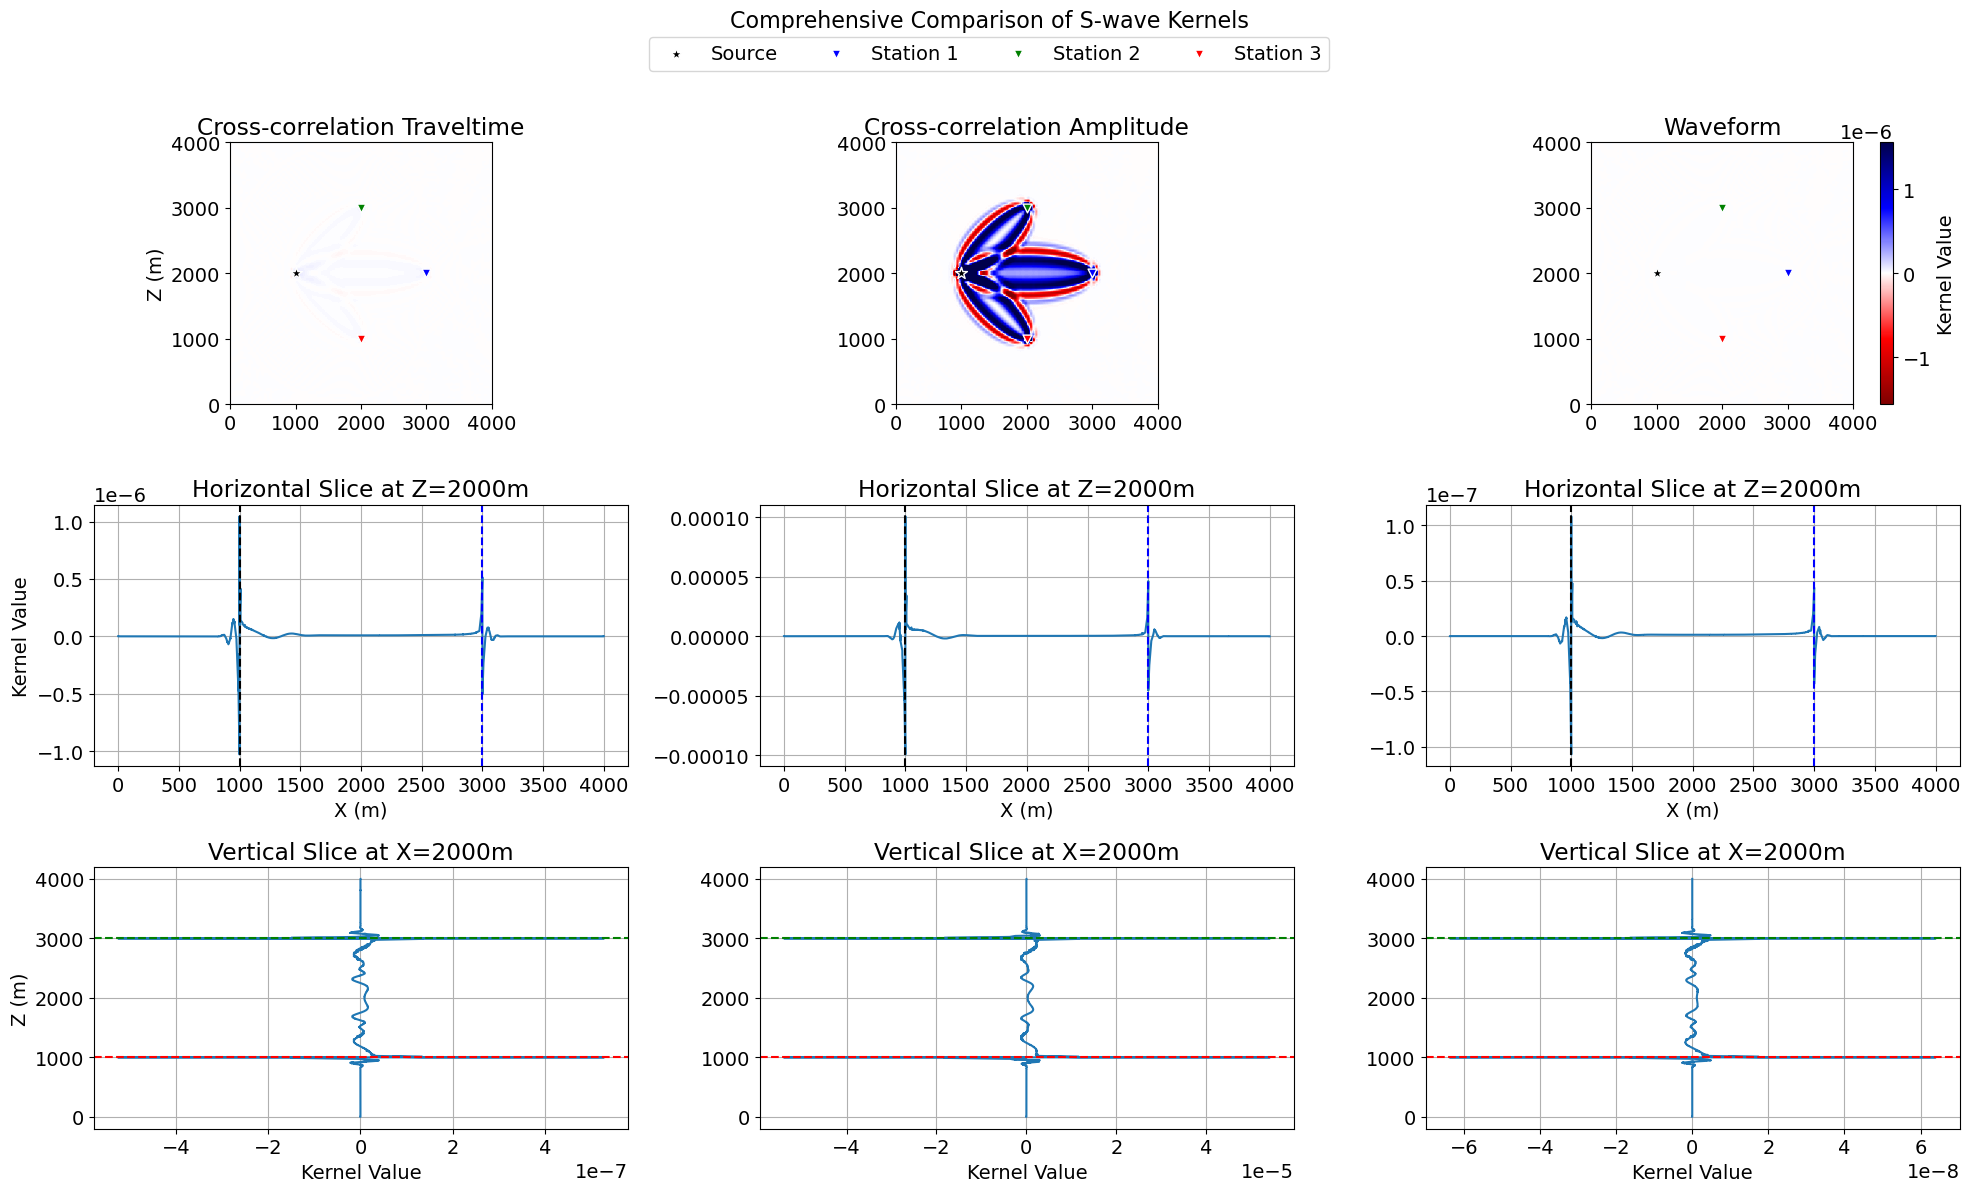

In [25]:
# Create a more comprehensive visualization of the three different kernel types
def plot_comprehensive_kernel_comparison():
    if not kernels:
        print("No kernel data available for visualization")
        return
    
    # Find common scale for better comparison
    all_beta_values = []
    for kernel_data in kernels.values():
        all_beta_values.extend(kernel_data[:, 4])
    
    common_vmax = max(abs(np.percentile(all_beta_values, 99)), abs(np.percentile(all_beta_values, 1)))
    
    # Create a comprehensive figure with all kernels
    fig = plt.figure(figsize=(20, 12))
    
    # Define a 3x3 grid for the figure
    gs = fig.add_gridspec(3, 3)
    
    # First row: full kernel maps
    kernel_axes = []
    for i, (misfit_type, kernel_data) in enumerate(kernels.items()):
        ax = fig.add_subplot(gs[0, i])
        
        x = kernel_data[:, 0]
        z = kernel_data[:, 1]
        beta = kernel_data[:, 4]
        
        X, Z, BETA = grid(x, z, beta)
        
        im = ax.imshow(BETA, vmax=common_vmax, vmin=-common_vmax, 
                       extent=[x.min(), x.max(), z.min(), z.max()],
                       cmap="seismic_r")
                       
        # Add title
        ax.set_title(f"{misfit_names[misfit_type]}")
        if i == 0:
            ax.set_ylabel("Z (m)")
        
        # Add source and receiver markers
        ax.scatter(1000, 2000, 80, marker="*", color="black", edgecolor="white", label="Source")
        ax.scatter(3000, 2000, 40, marker="v", color="blue", edgecolor="white", label="Station 1")
        ax.scatter(2000, 3000, 40, marker="v", color="green", edgecolor="white", label="Station 2")
        ax.scatter(2000, 1000, 40, marker="v", color="red", edgecolor="white", label="Station 3")
        
        if i == 2:
            cbar = fig.colorbar(im, ax=ax)
            cbar.set_label("Kernel Value")
        
        kernel_axes.append(ax)
    
    # Second row: horizontal slices at z=2000m (source and receiver 1 depth)
    z_index = 2000
    for i, (misfit_type, kernel_data) in enumerate(kernels.items()):
        ax = fig.add_subplot(gs[1, i])
        
        x = kernel_data[:, 0]
        z = kernel_data[:, 1]
        beta = kernel_data[:, 4]
        
        # Find points closest to the desired z-coordinate
        z_slice_indices = np.abs(z - z_index).argsort()[:1000]
        
        # Sort by x-coordinate
        sorted_indices = np.argsort(x[z_slice_indices])
        x_sorted = x[z_slice_indices][sorted_indices]
        beta_sorted = beta[z_slice_indices][sorted_indices]
        
        # Plot the slice
        ax.plot(x_sorted, beta_sorted)
        
        ax.axvline(x=1000, color='black', linestyle='--')
        ax.axvline(x=3000, color='blue', linestyle='--')
        
        ax.set_title(f"Horizontal Slice at Z={z_index}m")
        if i == 0:
            ax.set_ylabel("Kernel Value")
        ax.set_xlabel("X (m)")
        ax.grid(True)
    
    # Third row: vertical slices at x=2000m (receiver 2 and 3 x-coord)
    x_index = 2000
    for i, (misfit_type, kernel_data) in enumerate(kernels.items()):
        ax = fig.add_subplot(gs[2, i])
        
        x = kernel_data[:, 0]
        z = kernel_data[:, 1]
        beta = kernel_data[:, 4]
        
        # Find points closest to the desired x-coordinate
        x_slice_indices = np.abs(x - x_index).argsort()[:1000]
        
        # Sort by z-coordinate
        sorted_indices = np.argsort(z[x_slice_indices])
        z_sorted = z[x_slice_indices][sorted_indices]
        beta_sorted = beta[x_slice_indices][sorted_indices]
        
        # Plot the slice
        ax.plot(beta_sorted, z_sorted)
        
        ax.axhline(y=1000, color='red', linestyle='--')
        ax.axhline(y=3000, color='green', linestyle='--')
        
        ax.set_title(f"Vertical Slice at X={x_index}m")
        if i == 0:
            ax.set_ylabel("Z (m)")
        ax.set_xlabel("Kernel Value")
        ax.grid(True)
    
    # Add a main title and legend
    handles, labels = kernel_axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=4)
    
    fig.suptitle("Comprehensive Comparison of S-wave Kernels", fontsize=16, y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    return fig

# Plot a comprehensive comparison
if 'kernels' in locals() and kernels:
    plot_comprehensive_kernel_comparison()
else:
    print("Kernels not available for comparison. Run the adjoint simulations first.")

## Summary of Kernel Calculation Workflow

Here's a step-by-step summary of the workflow used in this notebook for calculating misfit kernels:

1. **Setup Domain and Model**
   - Define the computational domain (4000m x 4000m)
   - Configure source and receivers
   - Define initial and true velocity models with ~1% Vs perturbation

2. **Generate Forward Simulations**
   - Run forward simulation for true model to generate "observed" data
   - Run forward simulation for initial model to generate synthetic data

3. **Calculate Misfit and Adjoint Sources**
   - For each receiver and misfit type:
     - Apply pre-processing (detrending, tapering, filtering)
     - Calculate the misfit value
     - Compute the corresponding adjoint source

4. **Run Adjoint Simulations**
   - For each misfit type:
     - Set up adjoint simulation with proper adjoint sources
     - Run the adjoint simulation
     - Compute the sensitivity kernel

5. **Analyze Results**
   - Visualize kernels for different misfit types
   - Compare sensitivity patterns
   - Verify calculations with synthetic tests
   - Document all parameters for reproducibility

This workflow can be adapted to more complex models and scenarios by modifying the domain, velocity structure, source configuration, and receiver geometry.